In [1]:
import numpy as np
from scipy.special import expit, logit


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    Оракул должен поддерживать l2 регуляризацию.
    """

    def __init__(self, l2_coef):
        """
        Задание параметров оракула.
        l2_coef - коэффициент l2 регуляризации
        """
        self.l2_coef = l2_coef

    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        w - одномерный numpy array
        """
        if not isinstance(X, type(y)):
            m = X.dot(w) * y
        else:
            m = np.dot(w, X.T) * y
        lf = expit(m)
        return 0.5 * self.l2_coef * np.linalg.norm(w) ** 2 - np.log(lf + 0.000000001).mean(axis=0)

        return super().func(w)

    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        w - одномерный numpy array
        """
        if not isinstance(X, type(y)):
            m = X.dot(w) * y
            lf = - X.multiply((expit(-m) * y)[:, None])
        else:
            m = np.dot(w, X.T) * y
            lf = - (expit(-m) * y)[:, None] * X
        return lf.mean(axis=0) + self.l2_coef * w

        return super().grad(w)

In [2]:
def grad_finite_diff(function, w, eps=1e-8):
    """
    Возвращает численное значение градиента, подсчитанное по следующией формуле:
        result_i := (f(w + eps * e_i) - f(w)) / eps,
        где e_i - следующий вектор:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """
    grad = []
    e_i = np.eye(len(w[2])) * eps
    for i in range(0, len(w[2])):
        grad.append((function(w[0], w[1], w[2] + e_i[i]) - function(w[0], w[1], w[2])) / eps)
    return np.array(grad)

In [3]:
import numpy as np
import time
from scipy.special import expit


class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
        self, loss_function, step_alpha=1, step_beta=0,
        tolerance=1e-5, max_iter=1000, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        step_alpha - float, параметр выбора шага из текста задания
        step_beta- float, параметр выбора шага из текста задания
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход
        max_iter - максимальное число итераций
        **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.kwargs = kwargs
        self.__w = 0
        self.__accuracy = []

    def fit(self, X, y, w_0=None, trace=False, accuracy=False):
        """
        Обучение метода по выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        w_0 - начальное приближение в методе
        trace - переменная типа bool
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        w_now = w_0
        n = self.step_alpha
        my_oracle = BinaryLogistic(self.kwargs['l2_coef'])
        history = dict.fromkeys(['func', 'time'])
        history['func'] = []
        history['time'] = []
        weights = []

        for i in range(1, self.max_iter + 1):
            start_time = time.time()
            f_grad = my_oracle.grad(X, y, w_now)
            f = my_oracle.func(X, y, w_now)
            history['func'].append(f)

            if len(history['func']) > 1:
                if abs(history['func'][-1] - history['func'][-2]) < self.tolerance:
                    history['time'].append(time.time() - start_time)
                    self.__w = w_now
                    if accuracy:
                        return self.__accuracy, history
                    elif trace:
                        return history

            w_now = np.ravel(w_now - n * f_grad)
            weights.append(w_now)
            self.__w = w_now
            ans = self.predict(X)
            ans = np.sum(ans == y) / len(y)
            self.__accuracy.append(ans)
            n = self.step_alpha / (i ** self.step_beta)
            history['time'].append(time.time() - start_time)

        f = my_oracle.func(X, y, w_now)
        history['func'].append(f)
        if accuracy == True:
            return self.__accuracy, history
        elif trace:
            return history

    def predict(self, X):
        """
        Получение меток ответов на выборке X
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        return: одномерный numpy array с предсказаниями
        """
        p = self.predict_proba(X)
        pred = np.full(X.shape[0], 1)
        pred[np.where(p[:, 1] < 0.5)] = -1
        
        return pred

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """
        ans = np.zeros((X.shape[0], 2))
        if not isinstance(X, type(ans)):
            m = X.dot(self.__w)
        else:
            m = np.dot(self.__w, X.T)
        p = expit(m)
        ans[:, 1] = p
        ans[:, 0] = 1 - p
        return ans

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        return: float
        """
        my_oracle = BinaryLogistic(self.kwargs['l2_coef'])
        return my_oracle.func(X, y, self.__w)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        return: numpy array, размерность зависит от задачи
        """
        my_oracle = BinaryLogistic(self.kwargs['l2_coef'])
        return my_oracle.grad(X, y, self.__w)

    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self.__w
    
class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(
        self, loss_function, batch_size, step_alpha=1, step_beta=0,
        tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs
    ):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора.
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        batch_size - размер подвыборки, по которой считается градиент
        step_alpha - float, параметр выбора шага из текста задания
        step_beta- float, параметр выбора шага из текста задания
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если |f(x_{k+1}) - f(x_{k})| < tolerance: то выход
        max_iter - максимальное число итераций (эпох)
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        **kwargs - аргументы, необходимые для инициализации
        """
        # self.loss_function = loss_function
        self.batch_size = batch_size
        # self.step_alpha = step_alpha
        # self.step_beta = step_beta
        # self.max_iter = max_iter
        self.random_seed = random_seed
        self.__w = 0
        self.__accuracy = []
        # self.kwargs = kwargs
        self = GDClassifier.__init__(self, loss_function, step_alpha, step_beta, tolerance, max_iter, **kwargs)

    def fit(self, X, y, w_0=None, trace=False, log_freq=1, accuracy=False):
        """
        Обучение метода по выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        w_0 - начальное приближение в методе
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления.
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.
        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        np.random.seed(self.random_seed)
        batch_index = np.random.permutation(X.shape[0])

        n = self.step_alpha
        my_oracle = BinaryLogistic(self.kwargs['l2_coef'])
        history = dict.fromkeys(['func', 'time', 'weights_diff', 'epoch_num'])
        history['func'] = []
        history['time'] = []
        history['weights_diff'] = []
        history['epoch_num'] = []
        batch_index_first = 0
        num_ep_last = num_ep_now = 0
        
        objects_num = 0

        start_time = time.time()
        w_now = w_0
        weights_last = w_now
        while num_ep_now < self.max_iter:
            indexs = batch_index[batch_index_first:batch_index_first + self.batch_size]
            if len(indexs) < self.batch_size / 10:
                batch_index = np.random.permutation(X.shape[0])
                batch_index_first = 0
                indexs = batch_index[batch_index_first:batch_index_first + self.batch_size]
            f_grad = my_oracle.grad(X[indexs],
                                    y[indexs],
                                    w_now)
            batch_index_first += self.batch_size
            
            objects_num += self.batch_size

            w_now = np.ravel(w_now - n * f_grad)
            
            num_ep_now = objects_num / len(y)
            if num_ep_now - num_ep_last >= log_freq:
                f = my_oracle.func(X, y, w_now)
                history['func'].append(f)
                history['time'].append(time.time() - start_time)
                history['epoch_num'].append(num_ep_now)
                history['weights_diff'].append(np.linalg.norm(w_now - weights_last) ** 2)
                self.__w = w_now
                ans = self.predict(X)
                ans = np.sum(ans == y) / len(y)
                self.__accuracy.append(ans)
                weights_last = w_now
                start_time = time.time()
                num_ep_last = num_ep_now
                batch_index = np.random.permutation(X.shape[0])
                batch_index_first = 0
                n = self.step_alpha / (num_ep_now ** self.step_beta)
                
            if len(history['func']) > 1:
                if abs(history['func'][-1] - history['func'][-2]) < self.tolerance:
                    break

        f = my_oracle.func(X, y, w_now)
        history['func'].append(f)
        history['time'].append(time.time() - start_time)
        history['epoch_num'].append(num_ep_now)
        history['weights_diff'].append(np.linalg.norm(w_now - weights_last) ** 2)
        self.__w = w_now
        ans = self.predict(X)
        ans = np.sum(ans == y) / len(y)
        self.__accuracy.append(ans)
        if accuracy:
            return self.__accuracy, history
        elif trace:
            return history

    def predict(self, X):
        """
        Получение меток ответов на выборке X
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        return: одномерный numpy array с предсказаниями
        """
        
        return GDClassifier.predict(self, X)

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k
        """
        ans = np.zeros((X.shape[0], 2))
        if not isinstance(X, type(ans)):
            m = X.dot(self.__w)
        else:
            m = np.dot(self.__w, X.T)
        p = expit(m)
        ans[:, 1] = p
        ans[:, 0] = 1 - p
        return ans

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        return: float
        """
        my_oracle = BinaryLogistic(self.kwargs['l2_coef'])
        return my_oracle.func(X, y, self.__w)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        return: numpy array, размерность зависит от задачи
        """
        my_oracle = BinaryLogistic(self.kwargs['l2_coef'])
        return my_oracle.grad(X, y, self.__w)

    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self.__w

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import regex
from sklearn.feature_extraction.text import CountVectorizer

#отображение графиков в ноутбуке
%matplotlib inline 

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg' 

In [5]:
train = pd.read_csv("/Users/polinakrivula/Downloads/data_toxic/toxic_train.csv")
test = pd.read_csv("/Users/polinakrivula/Downloads/data_toxic/toxic_test.csv")

In [6]:
train['comment_text'] = train.comment_text.str.lower()
test['comment_text'] = test.comment_text.str.lower()

train['comment_text'] = train.comment_text.str.replace('[^a-zа-яё0-9]', ' ')
train['comment_text'] = train.comment_text.str.replace(' +', ' ')
test['comment_text'] = test.comment_text.str.replace('[^a-zа-яё0-9]', ' ')
test['comment_text'] = test.comment_text.str.replace(' +', ' ')

<ipython-input-6-ae761fb0a15d>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train['comment_text'] = train.comment_text.str.replace('[^a-zа-яё0-9]', ' ')
<ipython-input-6-ae761fb0a15d>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  train['comment_text'] = train.comment_text.str.replace(' +', ' ')
<ipython-input-6-ae761fb0a15d>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test['comment_text'] = test.comment_text.str.replace('[^a-zа-яё0-9]', ' ')
<ipython-input-6-ae761fb0a15d>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  test['comment_text'] = test.comment_text.str.replace(' +', ' ')


In [7]:
train.head(5)

Unnamed: 0                                       comment_text  is_toxic
0           0  explanation why the edits made under my userna...     False
1           1  d aww he matches this background colour i m se...     False
2           2  hey man i m really not trying to edit war it s...     False
3           3   more i can t make any real suggestions on imp...     False
4           4  you sir are my hero any chance you remember wh...     False

In [8]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test = vectorizer.transform(test['comment_text'])
X_train.toarray().shape

(52061, 89658)

In [9]:
vectorizer = CountVectorizer(min_df=0.0001)
X_train = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test = vectorizer.transform(test['comment_text'])

In [10]:
X_train.toarray().shape

(52061, 16050)

In [11]:
X_test.toarray().shape

(20676, 16050)

In [12]:
#токсичный комментарий == -1,  иначе 1
y_train = (train['is_toxic'].values.astype(np.int8) + 1) % 2
y_train[np.where(y_train == 0)] = -1
y_train.shape

(52061,)

In [13]:
y_test = (test['is_toxic'].values.astype(np.int8) + 1) % 2
y_test[np.where(y_test == 0)] = -1

Считаем численный и аналитический градиент и среднекватратичную ошибку

In [14]:
my_oracle = BinaryLogistic(l2_coef=0.01)
grad_analyt = my_oracle.grad(X_train, y_train, w=np.zeros(X_train.shape[1]))
grad_analyt = np.ravel(grad_analyt)
print(grad_analyt)

[-1.52705480e-03 -3.22698373e-03 -3.93768848e-04 ... -5.76247095e-05
 -3.84164730e-05 -7.68329460e-05]


In [15]:
grad_utilits = grad_finite_diff(my_oracle.func, [X_train, y_train, np.zeros(X_train.shape[1])])
print(grad_utilits)

[-1.52705626e-03 -3.22698535e-03 -3.93773902e-04 ... -5.76427794e-05
 -3.84248189e-05 -7.68385355e-05]


In [16]:
print(np.sum((grad_analyt - grad_utilits) ** 2))

1.4251527387402317e-12


Берем начальное приближение весов 0, шаг b=1, альфа меняем, l2_coef=1

In [17]:
parametrs_alpha_GDClassifier = dict.fromkeys(['step_alpha', 'accuracy', 'loss_func'])
parametrs_alpha_GDClassifier['step_alpha'] = []
parametrs_alpha_GDClassifier['accuracy'] = []
parametrs_alpha_GDClassifier['loss_func'] = []
for i in [0.00001, 0.0001, 0.01, 0.1, 0.5, 1, 5, 10]:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=i,
    step_beta=1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy, history = clf.fit(X_train, y_train, w_0=np.full(X_train.shape[1], 0), trace=True, accuracy=True)
    parametrs_alpha_GDClassifier['accuracy'].append(accuracy)
    parametrs_alpha_GDClassifier['step_alpha'].append(i)
    parametrs_alpha_GDClassifier['loss_func'].append(history['func'])

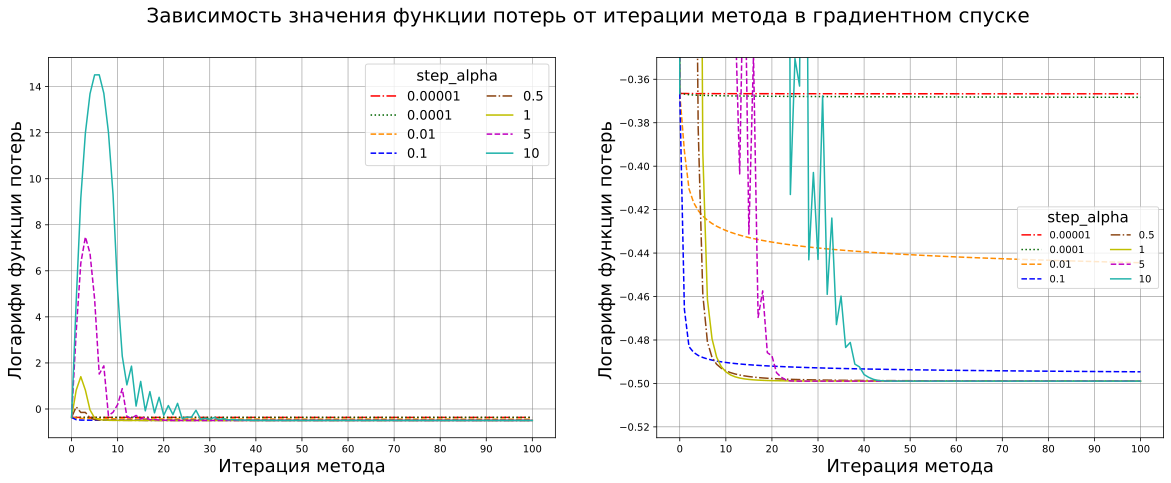

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость значения функции потерь от итерации метода в градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][0]), color='red', label='0.00001', linestyle='-.')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][1]), color='darkgreen', label='0.0001', linestyle='dotted')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][2]), color='darkorange', label='0.01', linestyle='dashed')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][3]),  color='b', label='0.1', linestyle='--')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][4]), color='saddlebrown', label='0.5', linestyle='-.')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][5]), color='y', label='1')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][6]), color='m', label='5',linestyle='--')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][7]), color='lightseagreen', label='10')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_alpha', title_fontsize=15, loc=1, fontsize=13, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][0]), color='red', label='0.00001', linestyle='-.')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][1]), color='darkgreen', label='0.0001', linestyle='dotted')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][2]), color='darkorange', label='0.01', linestyle='dashed')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][3]),  color='b', label='0.1', linestyle='--')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][4]), color='saddlebrown', label='0.5', linestyle='-.')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][5]), color='y', label='1')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][6]), color='m', label='5',linestyle='--')
plt.plot(np.log(parametrs_alpha_GDClassifier['loss_func'][7]), color='lightseagreen', label='10')
plt.ylim([-0.525, -0.35])
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_alpha', title_fontsize=15, fontsize=10, ncol=2)

plt.savefig("TASK2 step_alpha loss.pdf", bbox_inches = 'tight')
plt.show()

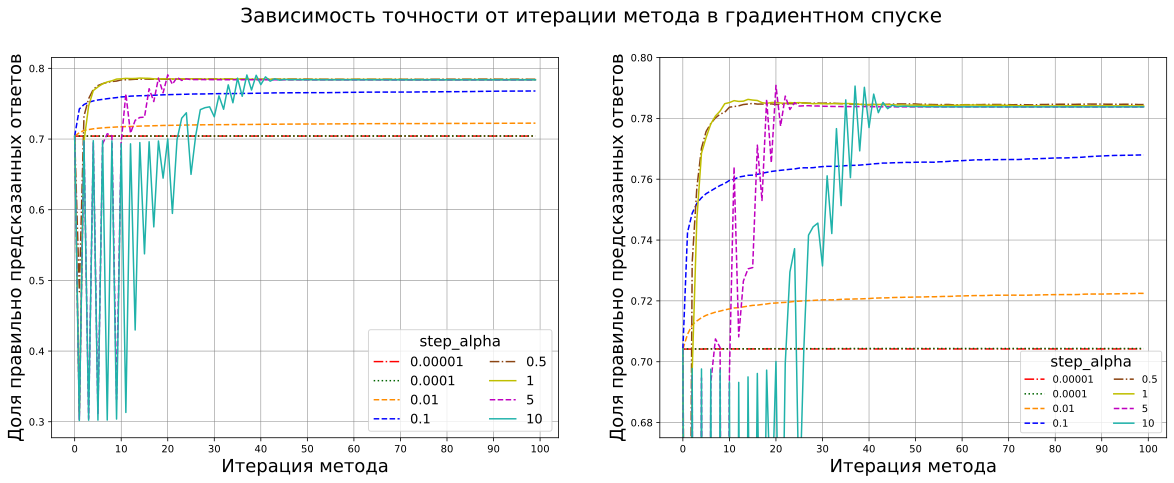

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость точности от итерации метода в градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_alpha_GDClassifier['accuracy'][0]), color='red', label='0.00001', linestyle='-.')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][1]), color='darkgreen', label='0.0001', linestyle='dotted')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][2]), color='darkorange', label='0.01', linestyle='dashed')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][3]),  color='b', label='0.1', linestyle='--')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][4]), color='saddlebrown', label='0.5', linestyle='-.')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][5]), color='y', label='1')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][6]), color='m', label='5', linestyle='--')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][7]), color='lightseagreen', label='10')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_alpha', title_fontsize=15, fontsize=13, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_alpha_GDClassifier['accuracy'][0]), color='red', label='0.00001', linestyle='-.')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][1]), color='darkgreen', label='0.0001', linestyle='dotted')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][2]), color='darkorange', label='0.01', linestyle='dashed')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][3]),  color='b', label='0.1', linestyle='--')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][4]), color='saddlebrown', label='0.5', linestyle='-.')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][5]), color='y', label='1')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][6]), color='m', label='5', linestyle='--')
plt.plot((parametrs_alpha_GDClassifier['accuracy'][7]), color='lightseagreen', label='10')
plt.ylim([0.675, 0.8])
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_alpha', title_fontsize=15, fontsize=10, loc='lower right', ncol=2)

plt.savefig("TASK2 step_alpha accuracy.pdf", bbox_inches = 'tight')
plt.show()

Берем начальное приближение весов 0, шаг b меняем, альфа 0.5, l2_coef=1

In [20]:
parametrs_betta_GDClassifier = dict.fromkeys(['step_betta', 'accuracy', 'loss_func'])
parametrs_betta_GDClassifier['step_betta'] = []
parametrs_betta_GDClassifier['accuracy'] = []
parametrs_betta_GDClassifier['loss_func'] = []
for i in [0.1, 0.25, 0.5, 1, 1.01, 1.1, 5, 10, 100]:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=i, tolerance=0, max_iter=500, l2_coef=1)
    accuracy, history = clf.fit(X_train, y_train, w_0=np.full(X_train.shape[1], 0), trace=True, accuracy=True)
    parametrs_betta_GDClassifier['accuracy'].append(accuracy)
    parametrs_betta_GDClassifier['step_betta'].append(i)
    parametrs_betta_GDClassifier['loss_func'].append(history['func'])

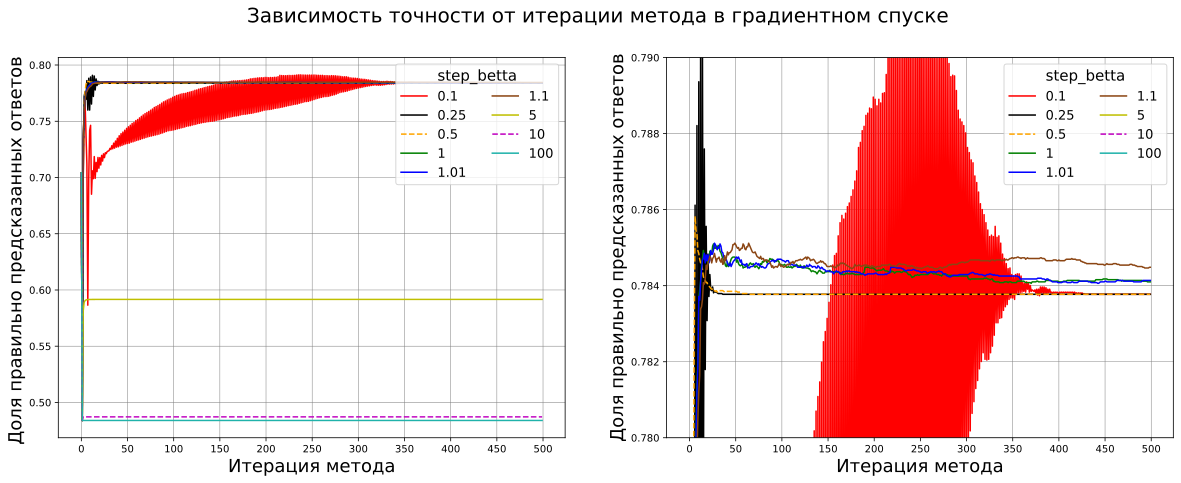

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость точности от итерации метода в градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов ', fontsize=18)
plt.xticks(list(range(0, 510, 50)))
plt.plot((parametrs_betta_GDClassifier['accuracy'][0]), color='red', label='0.1')
plt.plot((parametrs_betta_GDClassifier['accuracy'][1]), color='black', label='0.25')
plt.plot((parametrs_betta_GDClassifier['accuracy'][2]), color='orange', label='0.5', linestyle='--')
plt.plot((parametrs_betta_GDClassifier['accuracy'][3]), color='green', label='1')
plt.plot((parametrs_betta_GDClassifier['accuracy'][4]),  color='b', label='1.01')
plt.plot((parametrs_betta_GDClassifier['accuracy'][5]), color='saddlebrown', label='1.1')
plt.plot((parametrs_betta_GDClassifier['accuracy'][6]), color='y', label='5')
plt.plot((parametrs_betta_GDClassifier['accuracy'][7]), color='m', label='10', linestyle='--')
plt.plot((parametrs_betta_GDClassifier['accuracy'][8]), color='lightseagreen', label='100')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_betta', title_fontsize=15, loc=1, fontsize=13, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)
plt.xticks(list(range(0, 510, 50)))
plt.plot((parametrs_betta_GDClassifier['accuracy'][0]), color='red', label='0.1')
plt.plot((parametrs_betta_GDClassifier['accuracy'][1]), color='black', label='0.25')
plt.plot((parametrs_betta_GDClassifier['accuracy'][2]), color='orange', label='0.5', linestyle='--')
plt.plot((parametrs_betta_GDClassifier['accuracy'][3]), color='green', label='1')
plt.plot((parametrs_betta_GDClassifier['accuracy'][4]),  color='b', label='1.01')
plt.plot((parametrs_betta_GDClassifier['accuracy'][5]), color='saddlebrown', label='1.1')
plt.plot((parametrs_betta_GDClassifier['accuracy'][6]), color='y', label='5')
plt.plot((parametrs_betta_GDClassifier['accuracy'][7]), color='m', label='10', linestyle='--')
plt.plot((parametrs_betta_GDClassifier['accuracy'][8]), color='lightseagreen', label='100')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.ylim([0.78, 0.79])
plt.legend(title = 'step_betta', title_fontsize=15, fontsize=13, ncol=2)

plt.savefig("TASK2 step_betta accuracy.pdf", bbox_inches = 'tight')
plt.show()

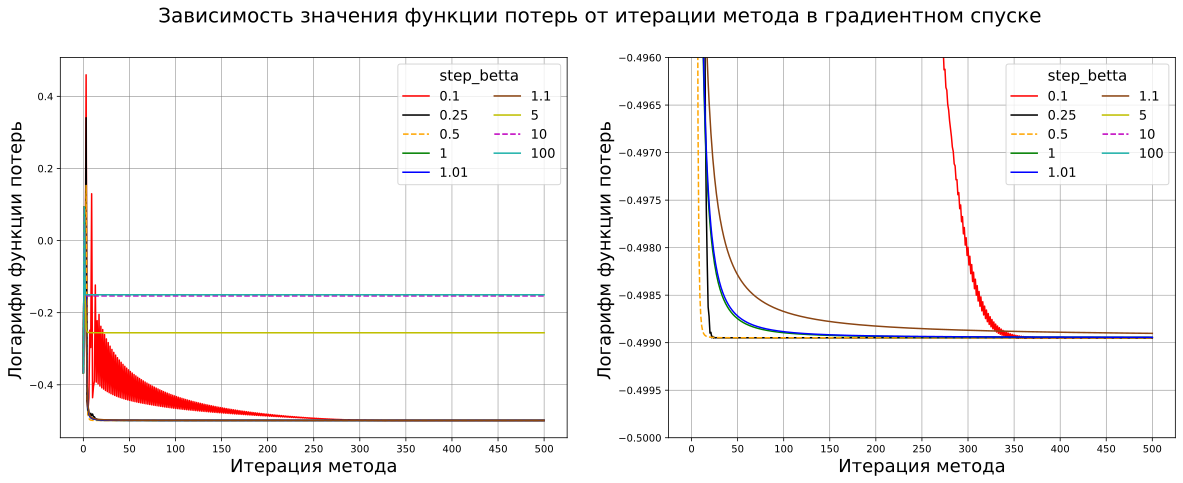

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость значения функции потерь от итерации метода в градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 510, 50)))
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][0]), color='red', label='0.1')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][1]), color='black', label='0.25')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][2]), color='orange', label='0.5', linestyle='--')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][3]), color='green', label='1')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][4]),  color='b', label='1.01')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][5]), color='saddlebrown', label='1.1')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][6]), color='y', label='5')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][7]), color='m', label='10', linestyle='--')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][8]), color='lightseagreen', label='100')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_betta', title_fontsize=15, loc=1, fontsize=13, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 510, 50)))
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][0]), color='red', label='0.1')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][1]), color='black', label='0.25')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][2]), color='orange', label='0.5', linestyle='--')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][3]), color='green', label='1')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][4]),  color='b', label='1.01')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][5]), color='saddlebrown', label='1.1')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][6]), color='y', label='5')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][7]), color='m', label='10', linestyle='--')
plt.plot(np.log(parametrs_betta_GDClassifier['loss_func'][8]), color='lightseagreen', label='100')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.ylim([-0.5, -0.496])
plt.legend(title = 'step_betta', title_fontsize=15, loc=1, fontsize=13, ncol=2)

plt.savefig("TASK2 step_betta loss.pdf", bbox_inches = 'tight')
plt.show()

шаг b 1.1, альфа 0.5, l2_coef=1, веса меняем

In [23]:
parametrs_w_GDClassifier = dict.fromkeys(['accuracy', 'loss_func'])
parametrs_w_GDClassifier['accuracy'] = []
parametrs_w_GDClassifier['loss_func'] = []
for i in [0, 1, 5, 20]:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy, history = clf.fit(X_train, y_train, w_0=np.full(X_train.shape[1], i), trace=True, accuracy=True)
    parametrs_w_GDClassifier['accuracy'].append(accuracy)
    parametrs_w_GDClassifier['loss_func'].append(history['func'])

mu, sigma = 0.5, 0.1
s = np.random.normal(mu, sigma, X_train.shape[1])
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
accuracy, history = clf.fit(X_train, y_train, w_0=s, trace=True, accuracy=True)
parametrs_w_GDClassifier['accuracy'].append(accuracy)
parametrs_w_GDClassifier['loss_func'].append(history['func'])

s = np.random.poisson(6.0, X_train.shape[1])
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
accuracy, history = clf.fit(X_train, y_train, w_0=s, trace=True, accuracy=True)
parametrs_w_GDClassifier['accuracy'].append(accuracy)
parametrs_w_GDClassifier['loss_func'].append(history['func'])


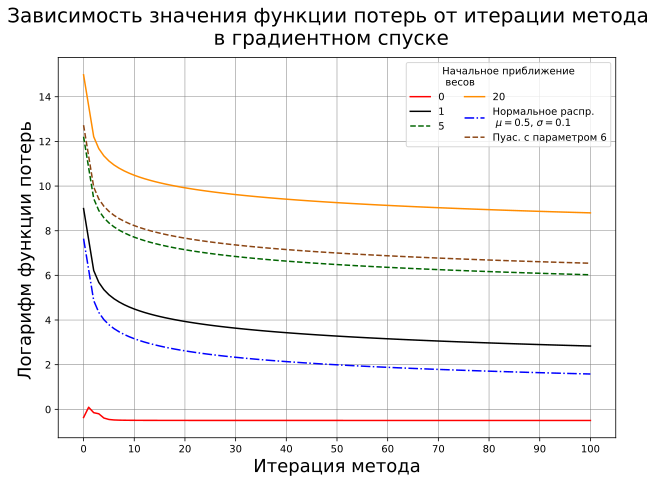

In [24]:
fig, ax = plt.subplots(figsize=(10,7))
plt.suptitle('Зависимость значения функции потерь от итерации метода\n в градиентном спуске', fontsize=20)

plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][0]), color='red', label='0')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][1]), color='black', label='1')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][2]), color='darkgreen', label='5', linestyle='--')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][3]), color='darkorange', label='20')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][4]),  color='b', label='Нормальное распр.\n $\mu=0.5$, $\sigma=0.1$', linestyle='-.')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][5]), color='saddlebrown', label='Пуас. с параметром 6', linestyle='--')

plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'Начальное приближение\n весов', title_fontsize=10, fontsize=10, ncol=2)
plt.savefig("TASK2 weights loss.pdf", bbox_inches = 'tight')
plt.show()

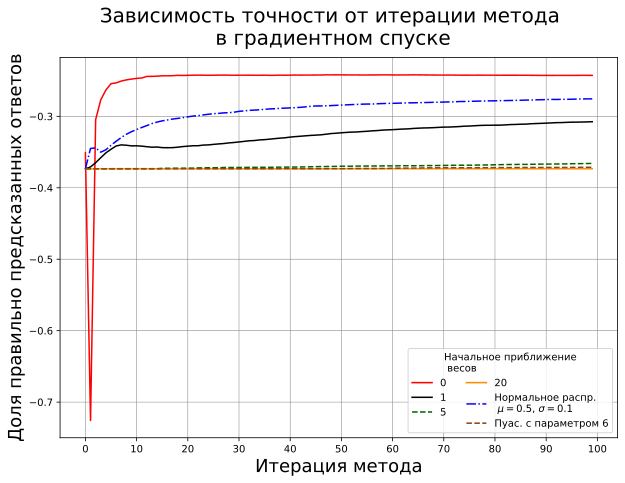

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
plt.suptitle('Зависимость точности от итерации метода\n в градиентном спуске', fontsize=20)

plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(np.log(parametrs_w_GDClassifier['accuracy'][0]), color='red', label='0')
plt.plot(np.log(parametrs_w_GDClassifier['accuracy'][1]), color='black', label='1')
plt.plot(np.log(parametrs_w_GDClassifier['accuracy'][2]), color='darkgreen', label='5', linestyle='--')
plt.plot(np.log(parametrs_w_GDClassifier['accuracy'][3]), color='darkorange', label='20')
plt.plot(np.log(parametrs_w_GDClassifier['accuracy'][4]),  color='b', label='Нормальное распр.\n $\mu=0.5$, $\sigma=0.1$', linestyle='-.')
plt.plot(np.log(parametrs_w_GDClassifier['accuracy'][5]), color='saddlebrown', label='Пуас. с параметром 6', linestyle='--')

plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'Начальное приближение\n весов', title_fontsize=10, fontsize=10, ncol=2)
plt.savefig("TASK2 weights accuracy.pdf", bbox_inches = 'tight')
plt.show()

СТОХАСТИЧЕСКИЙ

Берем начальное приближение весов 0, шаг b=1, альфа меняем, l2_coef=1

In [26]:
parametrs_alpha_SGDClassifier = dict.fromkeys(['step_alpha', 'accuracy', 'loss_func', 'epoch_num'])
parametrs_alpha_SGDClassifier['step_alpha'] = []
parametrs_alpha_SGDClassifier['accuracy'] = []
parametrs_alpha_SGDClassifier['loss_func'] = []
parametrs_alpha_SGDClassifier['epoch_num'] = []
for i in [0.00001, 0.0001, 0.01, 0.1, 0.5, 1, 5, 10]:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=i, batch_size=10000,
                        step_beta=1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy, history = clf.fit(X_train, y_train, w_0=np.full(X_train.shape[1], 0), trace=True, accuracy=True)
    parametrs_alpha_SGDClassifier['accuracy'].append(accuracy)
    parametrs_alpha_SGDClassifier['step_alpha'].append(i)
    parametrs_alpha_SGDClassifier['loss_func'].append(history['func'])
    parametrs_alpha_SGDClassifier['epoch_num'].append(history['epoch_num'])

In [27]:
len(history['epoch_num'])

87

In [28]:
len(accuracy)

87

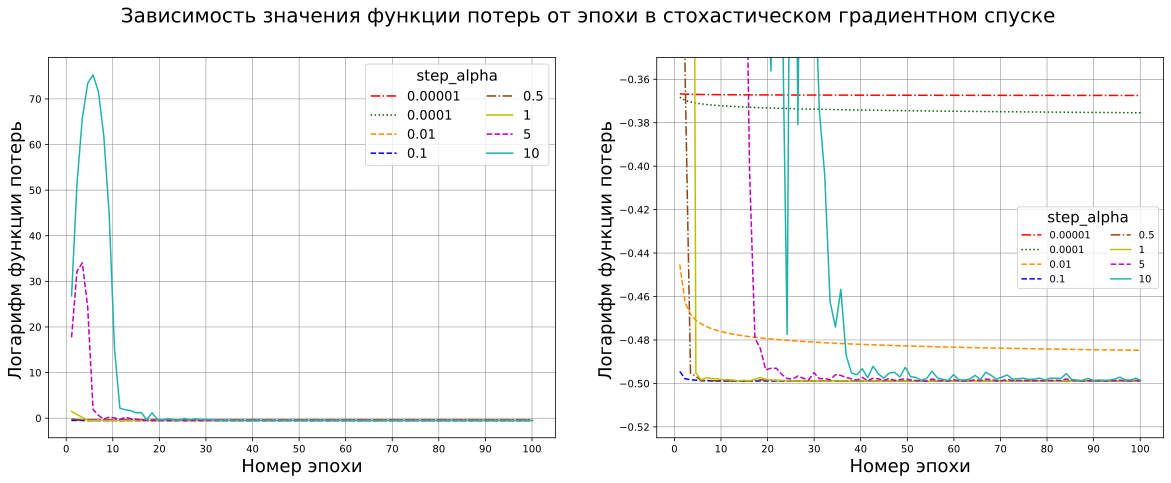

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость значения функции потерь от эпохи в стохастическом градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][0], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][0]), color='red', label='0.00001', linestyle='-.')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][1], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][1]), color='darkgreen', label='0.0001', linestyle='dotted')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][2], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][2]), color='darkorange', label='0.01', linestyle='dashed')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][3], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][3]),  color='b', label='0.1', linestyle='--')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][4], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][4]), color='saddlebrown', label='0.5', linestyle='-.')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][5], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][5]), color='y', label='1')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][6], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][6]), color='m', label='5', linestyle='--')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][7], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][7]), color='lightseagreen', label='10')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_alpha', title_fontsize=15, loc=1, fontsize=13, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][0], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][0]), color='red', label='0.00001', linestyle='-.')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][1], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][1]), color='darkgreen', label='0.0001', linestyle='dotted')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][2], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][2]), color='darkorange', label='0.01', linestyle='dashed')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][3], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][3]),  color='b', label='0.1', linestyle='--')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][4], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][4]), color='saddlebrown', label='0.5', linestyle='-.')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][5], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][5]), color='y', label='1')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][6], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][6]), color='m', label='5', linestyle='--')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][7], 
         np.log(parametrs_alpha_SGDClassifier['loss_func'][7]), color='lightseagreen', label='10')
plt.ylim([-0.525, -0.35])
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_alpha', title_fontsize=15, fontsize=10, ncol=2)

plt.savefig("TASK2 step_alpha loss SGDClassifier.pdf", bbox_inches = 'tight')
plt.show()

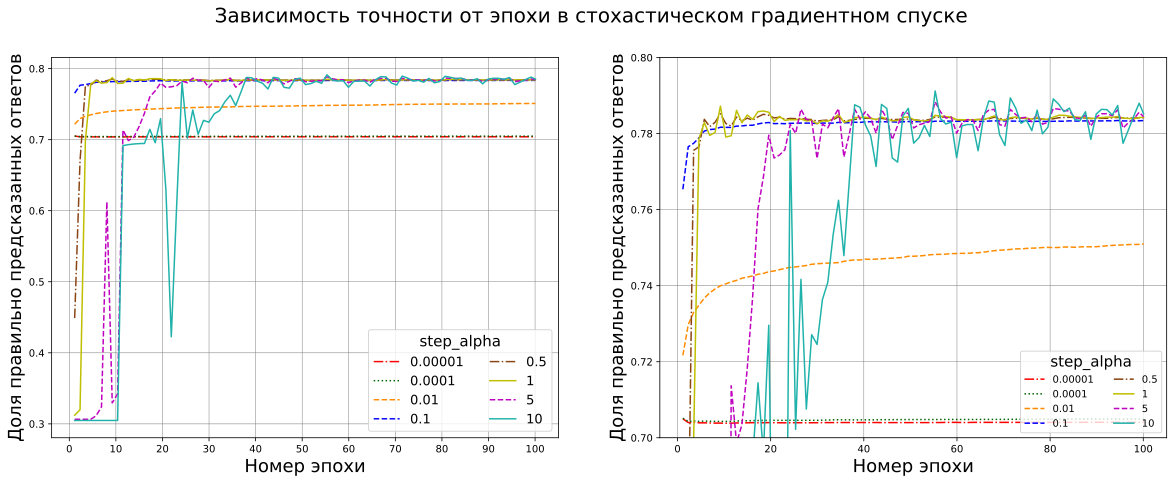

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость точности от эпохи в стохастическом градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)

plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][0], 
         (parametrs_alpha_SGDClassifier['accuracy'][0]), color='red', label='0.00001', linestyle='-.')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][1], 
         (parametrs_alpha_SGDClassifier['accuracy'][1]), color='darkgreen', label='0.0001', linestyle='dotted')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][2], 
         (parametrs_alpha_SGDClassifier['accuracy'][2]), color='darkorange', label='0.01', linestyle='dashed')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][3], 
         (parametrs_alpha_SGDClassifier['accuracy'][3]),  color='b', label='0.1', linestyle='--')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][4], 
         (parametrs_alpha_SGDClassifier['accuracy'][4]), color='saddlebrown', label='0.5', linestyle='-.')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][5], 
         (parametrs_alpha_SGDClassifier['accuracy'][5]), color='y', label='1')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][6], 
         (parametrs_alpha_SGDClassifier['accuracy'][6]), color='m', label='5', linestyle='--')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][7], 
         (parametrs_alpha_SGDClassifier['accuracy'][7]), color='lightseagreen', label='10')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_alpha', title_fontsize=15, fontsize=13, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)

plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][0], 
         (parametrs_alpha_SGDClassifier['accuracy'][0]), color='red', label='0.00001', linestyle='-.')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][1], 
         (parametrs_alpha_SGDClassifier['accuracy'][1]), color='darkgreen', label='0.0001', linestyle='dotted')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][2], 
         (parametrs_alpha_SGDClassifier['accuracy'][2]), color='darkorange', label='0.01', linestyle='dashed')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][3], 
         (parametrs_alpha_SGDClassifier['accuracy'][3]),  color='b', label='0.1', linestyle='--')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][4], 
         (parametrs_alpha_SGDClassifier['accuracy'][4]), color='saddlebrown', label='0.5', linestyle='-.')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][5], 
         (parametrs_alpha_SGDClassifier['accuracy'][5]), color='y', label='1')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][6], 
         (parametrs_alpha_SGDClassifier['accuracy'][6]), color='m', label='5', linestyle='--')
plt.plot(parametrs_alpha_SGDClassifier['epoch_num'][7], 
         (parametrs_alpha_SGDClassifier['accuracy'][7]), color='lightseagreen', label='10')
plt.ylim([0.7, 0.8])

plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_alpha', title_fontsize=15, fontsize=10, loc='lower right', ncol=2)

plt.savefig("TASK2 step_alpha accuracy SDC.pdf", bbox_inches = 'tight')
plt.show()

Берем начальное приближение весов 0, шаг b меняем, альфа 0.5, l2_coef=1

In [35]:
parametrs_betta_SGDClassifier = dict.fromkeys(['step_betta', 'accuracy', 'loss_func', 'epoch_num'])
parametrs_betta_SGDClassifier['step_betta'] = []
parametrs_betta_SGDClassifier['accuracy'] = []
parametrs_betta_SGDClassifier['loss_func'] = []
parametrs_betta_SGDClassifier['epoch_num'] = []
for i in [0.00001, 0.0001, 0.01, 0.1, 0.5, 1, 5, 10]:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=i, batch_size=10000,
                        step_beta=1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy, history = clf.fit(X_train, y_train, w_0=np.full(X_train.shape[1], 0), trace=True, accuracy=True)
    parametrs_betta_SGDClassifier['accuracy'].append(accuracy)
    parametrs_betta_SGDClassifier['step_betta'].append(i)
    parametrs_betta_SGDClassifier['loss_func'].append(history['func'])
    parametrs_betta_SGDClassifier['epoch_num'].append(history['epoch_num'])

KeyError: 'epoch_num'

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
plt.suptitle('Зависимость значения функции потерь от итерации метода\n в градиентном спуске', fontsize=20)

plt.xlabel('Итерация метода', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][0]), color='red', label='0')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][1]), color='black', label='1')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][2]), color='darkgreen', label='5', linestyle='--')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][3]), color='darkorange', label='20')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][4]),  color='b', label='Нормальное распр.\n $\mu=0.5$, $\sigma=0.1$', linestyle='-.')
plt.plot(np.log(parametrs_w_GDClassifier['loss_func'][5]), color='saddlebrown', label='Пуас. с параметром 6', linestyle='--')

plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'Начальное приближение\n весов', title_fontsize=10, fontsize=10, ncol=2)
plt.savefig("TASK2 weights loss.pdf", bbox_inches = 'tight')
plt.show()

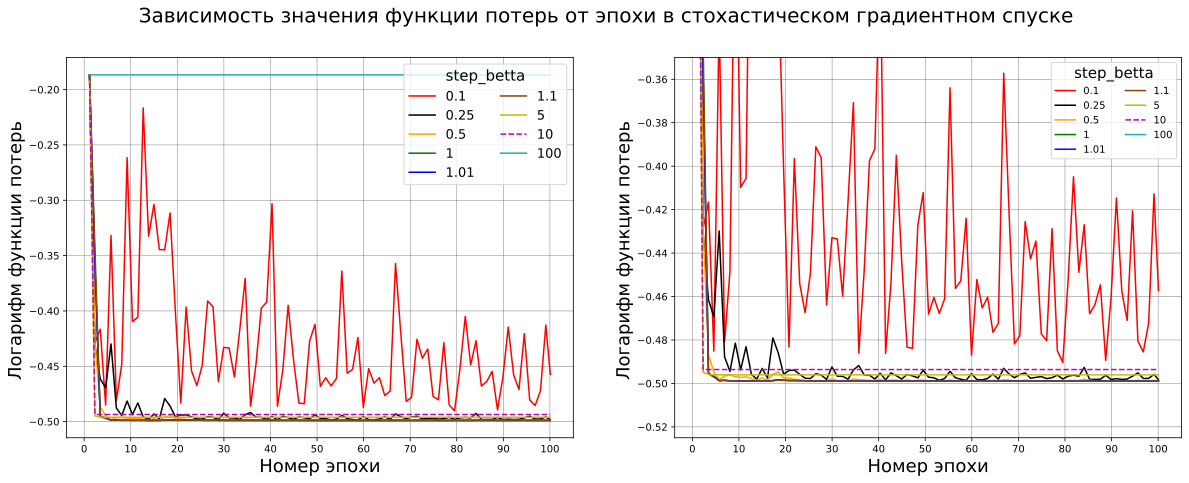

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость значения функции потерь от эпохи в стохастическом градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][0], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][0]), color='red', label='0.1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][1], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][1]), color='black', label='0.25')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][2], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][2]), color='orange', label='0.5')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][3], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][3]),  color='green', label='1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][4], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][4]), color='b', label='1.01')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][5], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][5]), color='saddlebrown', label='1.1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][6], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][6]), color='y', label='5')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][7], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][7]), color='m', label='10', linestyle='--')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][8], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][8]), color='lightseagreen', label='100')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_betta', title_fontsize=15, loc=1, fontsize=13, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][0], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][0]), color='red', label='0.1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][1], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][1]), color='black', label='0.25')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][2], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][2]), color='orange', label='0.5')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][3], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][3]),  color='green', label='1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][4], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][4]), color='b', label='1.01')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][5], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][5]), color='saddlebrown', label='1.1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][6], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][6]), color='y', label='5')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][7], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][7]), color='m', label='10', linestyle='--')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][8], 
         np.log(parametrs_betta_SGDClassifier['loss_func'][8]), color='lightseagreen', label='100')
plt.ylim([-0.525, -0.35])
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'step_betta', title_fontsize=15, fontsize=10, ncol=2, loc=1)

plt.savefig("TASK2 step_betta loss SGDClassifier.pdf", bbox_inches = 'tight')
plt.show()

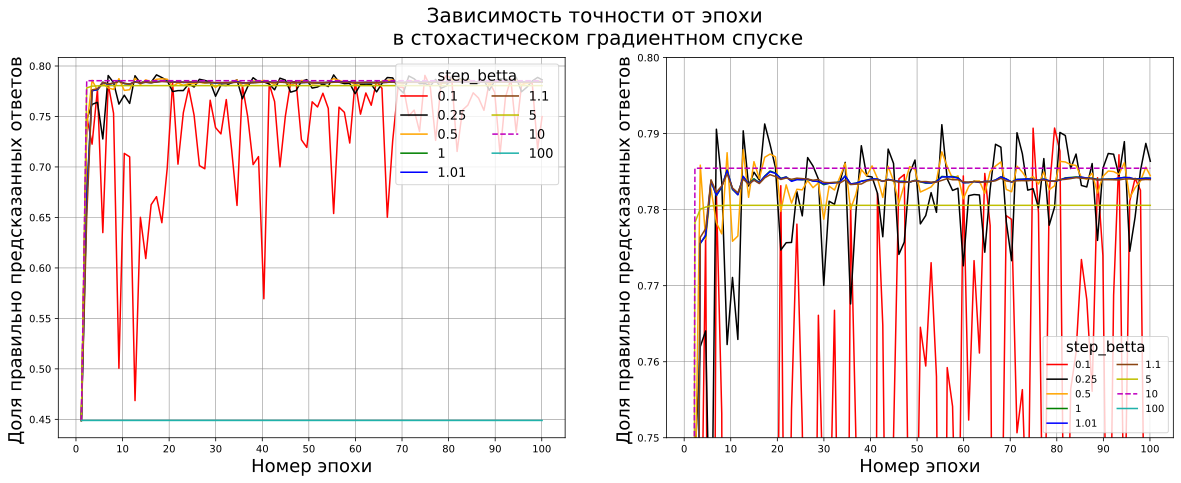

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость точности от эпохи \nв стохастическом градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))

plt.plot(parametrs_betta_SGDClassifier['epoch_num'][0], 
         (parametrs_betta_SGDClassifier['accuracy'][0]), color='red', label='0.1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][1], 
         (parametrs_betta_SGDClassifier['accuracy'][1]), color='black', label='0.25')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][2], 
         (parametrs_betta_SGDClassifier['accuracy'][2]), color='orange', label='0.5')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][3], 
         (parametrs_betta_SGDClassifier['accuracy'][3]),  color='green', label='1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][4], 
         (parametrs_betta_SGDClassifier['accuracy'][4]), color='b', label='1.01')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][5], 
         (parametrs_betta_SGDClassifier['accuracy'][5]), color='saddlebrown', label='1.1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][6], 
         (parametrs_betta_SGDClassifier['accuracy'][6]), color='y', label='5')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][7], 
         (parametrs_betta_SGDClassifier['accuracy'][7]), color='m', label='10', linestyle='--')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][8], 
         (parametrs_betta_SGDClassifier['accuracy'][8]), color='lightseagreen', label='100')
plt.grid(which='major', color='grey', linewidth=0.5)
plt.legend(title='step_betta', title_fontsize=15, loc=1, fontsize=13, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][0], 
         (parametrs_betta_SGDClassifier['accuracy'][0]), color='red', label='0.1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][1], 
         (parametrs_betta_SGDClassifier['accuracy'][1]), color='black', label='0.25')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][2], 
         (parametrs_betta_SGDClassifier['accuracy'][2]), color='orange', label='0.5')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][3], 
         (parametrs_betta_SGDClassifier['accuracy'][3]),  color='green', label='1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][4], 
         (parametrs_betta_SGDClassifier['accuracy'][4]), color='b', label='1.01')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][5], 
         (parametrs_betta_SGDClassifier['accuracy'][5]), color='saddlebrown', label='1.1')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][6], 
         (parametrs_betta_SGDClassifier['accuracy'][6]), color='y', label='5')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][7], 
         (parametrs_betta_SGDClassifier['accuracy'][7]), color='m', label='10', linestyle='--')
plt.plot(parametrs_betta_SGDClassifier['epoch_num'][8], 
         (parametrs_betta_SGDClassifier['accuracy'][8]), color='lightseagreen', label='100')
plt.ylim([0.75, 0.8])
plt.grid(which='major', color='grey', linewidth = 0.5)
plt.legend(title = 'step_betta', title_fontsize=15, fontsize=10, ncol=2)

plt.savefig("TASK2 step_betta accuracy SGDClassifier.pdf", bbox_inches = 'tight')
plt.show()

In [41]:
parametrs_w_SGDClassifier = dict.fromkeys(['w', 'accuracy', 'loss_func', 'epoch_num'])
parametrs_w_SGDClassifier['w'] = []
parametrs_w_SGDClassifier['accuracy'] = []
parametrs_w_SGDClassifier['loss_func'] = []
parametrs_w_SGDClassifier['epoch_num'] = []
for i in [0, 1, 5, 20]:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
                        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy, history = clf.fit(X_train, y_train, w_0=np.full(X_train.shape[1], i), trace=True, accuracy=True)
    parametrs_w_SGDClassifier['accuracy'].append(accuracy)
    parametrs_w_SGDClassifier['w'].append(i)
    parametrs_w_SGDClassifier['loss_func'].append(history['func'])
    parametrs_w_SGDClassifier['epoch_num'].append(history['epoch_num'])

mu, sigma = 0.5, 0.1
s = np.random.normal(mu, sigma, X_train.shape[1])
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1, batch_size=10000)
accuracy, history = clf.fit(X_train, y_train, w_0=s, trace=True, accuracy=True)
parametrs_w_SGDClassifier['accuracy'].append(accuracy)
parametrs_w_SGDClassifier['loss_func'].append(history['func'])
parametrs_w_SGDClassifier['epoch_num'].append(history['epoch_num'])

s = np.random.poisson(6.0, X_train.shape[1])
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1, batch_size=10000)
accuracy, history = clf.fit(X_train, y_train, w_0=s, trace=True, accuracy=True)
parametrs_w_SGDClassifier['accuracy'].append(accuracy)
parametrs_w_SGDClassifier['loss_func'].append(history['func'])
parametrs_w_SGDClassifier['epoch_num'].append(history['epoch_num'])

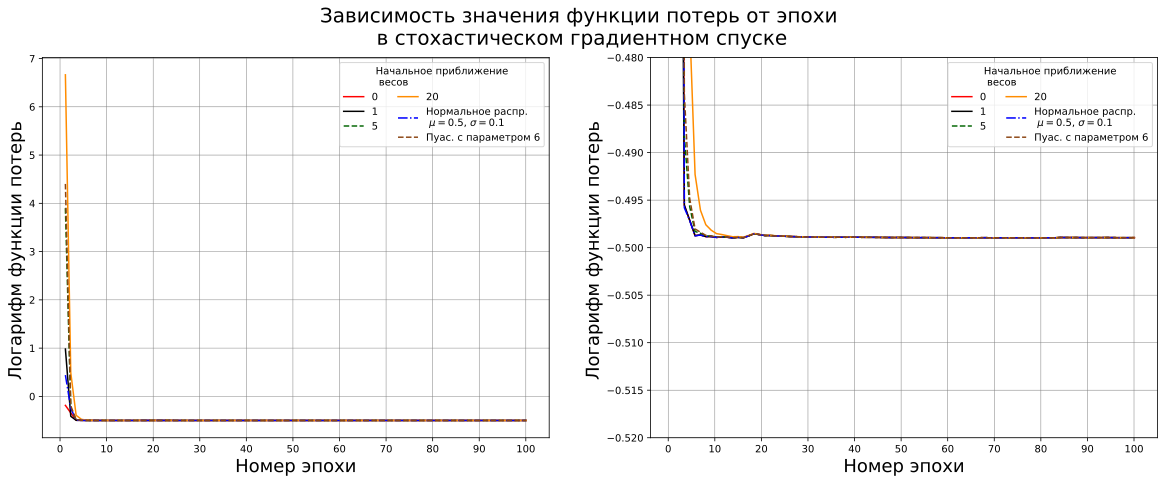

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость значения функции потерь от эпохи \nв стохастическом градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_w_SGDClassifier['epoch_num'][0],
         np.log(parametrs_w_SGDClassifier['loss_func'][0]), color='red', label='0')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][1],
         np.log(parametrs_w_SGDClassifier['loss_func'][1]), color='black', label='1')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][2],
         np.log(parametrs_w_SGDClassifier['loss_func'][2]), color='darkgreen', label='5', linestyle='--')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][3],
         np.log(parametrs_w_SGDClassifier['loss_func'][3]), color='darkorange', label='20')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][4],
         np.log(parametrs_w_SGDClassifier['loss_func'][4]),  color='b', label='Нормальное распр.\n $\mu=0.5$, $\sigma=0.1$', linestyle='-.')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][5],
         np.log(parametrs_w_SGDClassifier['loss_func'][5]), color='saddlebrown', label='Пуас. с параметром 6', linestyle='--')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'Начальное приближение\n весов', title_fontsize=10, fontsize=10, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_w_SGDClassifier['epoch_num'][0],
         np.log(parametrs_w_SGDClassifier['loss_func'][0]), color='red', label='0')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][1],
         np.log(parametrs_w_SGDClassifier['loss_func'][1]), color='black', label='1')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][2],
         np.log(parametrs_w_SGDClassifier['loss_func'][2]), color='darkgreen', label='5', linestyle='--')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][3],
         np.log(parametrs_w_SGDClassifier['loss_func'][3]), color='darkorange', label='20')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][4],
         np.log(parametrs_w_SGDClassifier['loss_func'][4]),  color='b', label='Нормальное распр.\n $\mu=0.5$, $\sigma=0.1$', linestyle='-.')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][5],
         np.log(parametrs_w_SGDClassifier['loss_func'][5]), color='saddlebrown', label='Пуас. с параметром 6', linestyle='--')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.ylim([-0.52, -0.48])
plt.legend(title = 'Начальное приближение\n весов', title_fontsize=10, fontsize=10, ncol=2)

plt.savefig("TASK2 weights loss SGD.pdf", bbox_inches = 'tight')
plt.show()

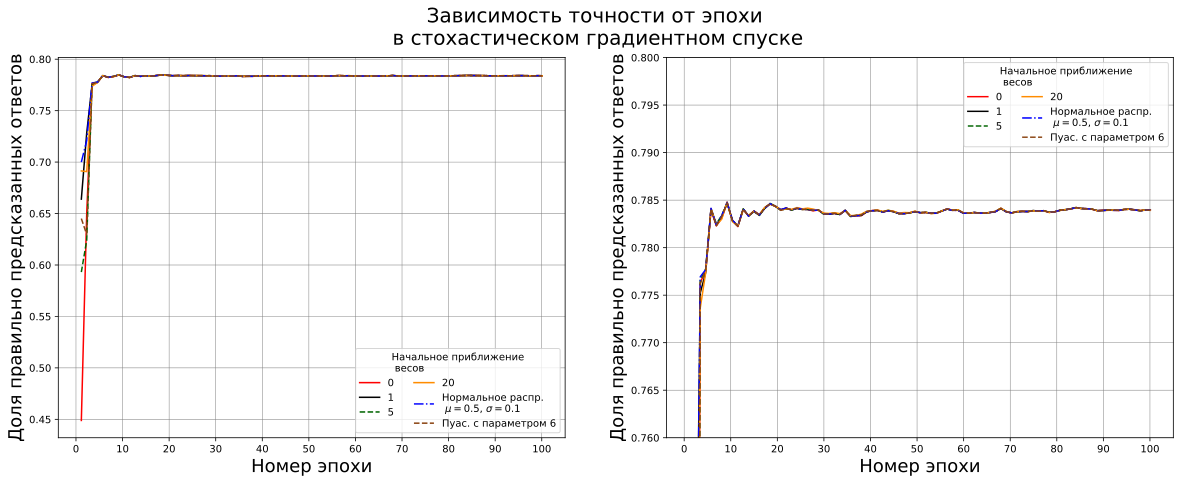

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость точности от эпохи \nв стохастическом градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_w_SGDClassifier['epoch_num'][0],
         (parametrs_w_SGDClassifier['accuracy'][0]), color='red', label='0')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][1],
         (parametrs_w_SGDClassifier['accuracy'][1]), color='black', label='1')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][2],
         (parametrs_w_SGDClassifier['accuracy'][2]), color='darkgreen', label='5', linestyle='--')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][3],
         (parametrs_w_SGDClassifier['accuracy'][3]), color='darkorange', label='20')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][4],
         (parametrs_w_SGDClassifier['accuracy'][4]),  color='b', label='Нормальное распр.\n $\mu=0.5$, $\sigma=0.1$', linestyle='-.')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][5],
         (parametrs_w_SGDClassifier['accuracy'][5]), color='saddlebrown', label='Пуас. с параметром 6', linestyle='--')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'Начальное приближение\n весов', title_fontsize=10, fontsize=10, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_w_SGDClassifier['epoch_num'][0],
         (parametrs_w_SGDClassifier['accuracy'][0]), color='red', label='0')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][1],
         (parametrs_w_SGDClassifier['accuracy'][1]), color='black', label='1')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][2],
         (parametrs_w_SGDClassifier['accuracy'][2]), color='darkgreen', label='5', linestyle='--')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][3],
         (parametrs_w_SGDClassifier['accuracy'][3]), color='darkorange', label='20')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][4],
         (parametrs_w_SGDClassifier['accuracy'][4]),  color='b', label='Нормальное распр.\n $\mu=0.5$, $\sigma=0.1$', linestyle='-.')
plt.plot(parametrs_w_SGDClassifier['epoch_num'][5],
         (parametrs_w_SGDClassifier['accuracy'][5]), color='saddlebrown', label='Пуас. с параметром 6', linestyle='--')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'Начальное приближение\n весов', title_fontsize=10, fontsize=10, ncol=2)
plt.ylim([0.76, 0.8])

plt.savefig("TASK2 weights accuracy SGD.pdf", bbox_inches = 'tight')
plt.show()

шаг b 1.1, альфа 0.5, l2_coef=1, веса нулевые, batch меняем

In [46]:
parametrs_batch_SGDClassifier = dict.fromkeys(['batch', 'accuracy', 'loss_func', 'epoch_num'])
parametrs_batch_SGDClassifier['batch'] = []
parametrs_batch_SGDClassifier['accuracy'] = []
parametrs_batch_SGDClassifier['loss_func'] = []
parametrs_batch_SGDClassifier['epoch_num'] = []
for i in [500, 1000, 5000, 10000, 25000, 50000, 100000]:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=i,
                        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy, history = clf.fit(X_train, y_train, w_0=np.full(X_train.shape[1], 0), trace=True, accuracy=True)
    parametrs_batch_SGDClassifier['accuracy'].append(accuracy)
    parametrs_batch_SGDClassifier['batch'].append(i)
    parametrs_batch_SGDClassifier['loss_func'].append(history['func'])
    parametrs_batch_SGDClassifier['epoch_num'].append(history['epoch_num'])

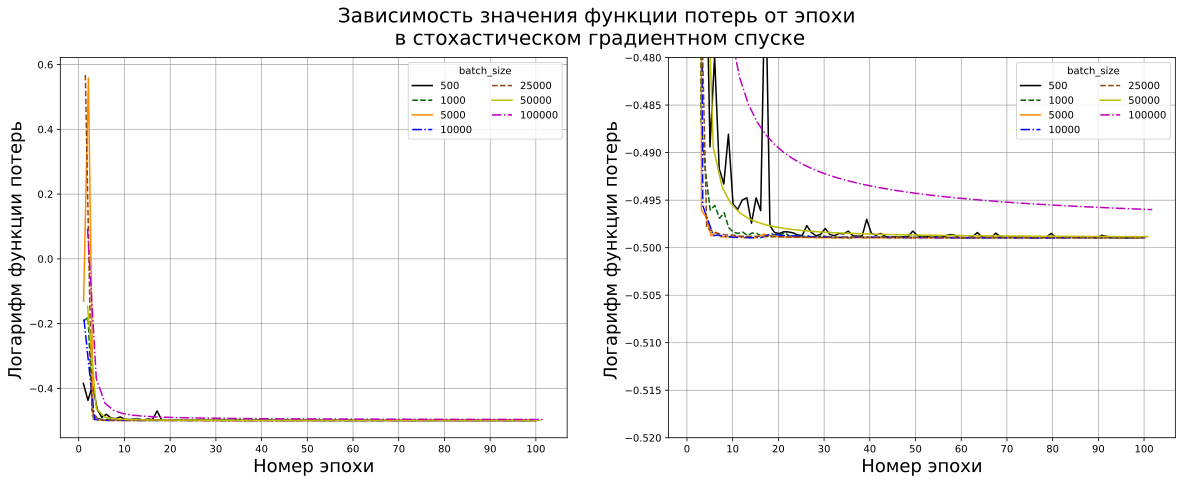

In [47]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость значения функции потерь от эпохи \nв стохастическом градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))

plt.plot(parametrs_batch_SGDClassifier['epoch_num'][0],
         np.log(parametrs_batch_SGDClassifier['loss_func'][0]), color='black', label='500')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][1],
         np.log(parametrs_batch_SGDClassifier['loss_func'][1]), color='darkgreen', label='1000', linestyle='--')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][2],
         np.log(parametrs_batch_SGDClassifier['loss_func'][2]), color='darkorange', label='5000')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][3],
         np.log(parametrs_batch_SGDClassifier['loss_func'][3]),  color='b', label='10000', linestyle='-.')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][4],
         np.log(parametrs_batch_SGDClassifier['loss_func'][4]), color='saddlebrown', label='25000', linestyle='--')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][5],
         np.log(parametrs_batch_SGDClassifier['loss_func'][5]), color='y', label='50000')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][6],
         np.log(parametrs_batch_SGDClassifier['loss_func'][6]), color='m', label='100000', linestyle='-.')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'batch_size', title_fontsize=10, fontsize=10, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Логарифм функции потерь ', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][0],
         np.log(parametrs_batch_SGDClassifier['loss_func'][0]), color='black', label='500')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][1],
         np.log(parametrs_batch_SGDClassifier['loss_func'][1]), color='darkgreen', label='1000', linestyle='--')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][2],
         np.log(parametrs_batch_SGDClassifier['loss_func'][2]), color='darkorange', label='5000')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][3],
         np.log(parametrs_batch_SGDClassifier['loss_func'][3]),  color='b', label='10000', linestyle='-.')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][4],
         np.log(parametrs_batch_SGDClassifier['loss_func'][4]), color='saddlebrown', label='25000', linestyle='--')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][5],
         np.log(parametrs_batch_SGDClassifier['loss_func'][5]), color='y', label='50000')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][6],
         np.log(parametrs_batch_SGDClassifier['loss_func'][6]), color='m', label='100000', linestyle='-.')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.ylim([-0.52, -0.48])
plt.legend(title = 'batch_size', title_fontsize=10, fontsize=10, ncol=2)

plt.savefig("TASK2 batch loss SGD.pdf", bbox_inches = 'tight')
plt.show()

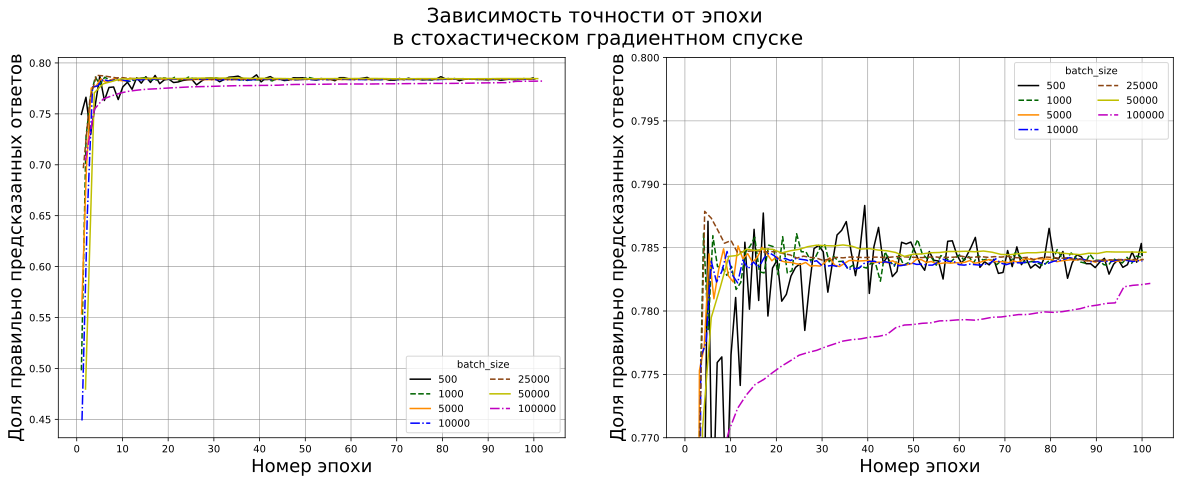

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(20,7))
plt.suptitle('Зависимость точности от эпохи \nв стохастическом градиентном спуске', fontsize=20)

plt.subplot(1, 2, 1)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][0],
         (parametrs_batch_SGDClassifier['accuracy'][0]), color='black', label='500')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][1],
         (parametrs_batch_SGDClassifier['accuracy'][1]), color='darkgreen', label='1000', linestyle='--')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][2],
         (parametrs_batch_SGDClassifier['accuracy'][2]), color='darkorange', label='5000')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][3],
         (parametrs_batch_SGDClassifier['accuracy'][3]),  color='b', label='10000', linestyle='-.')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][4],
         (parametrs_batch_SGDClassifier['accuracy'][4]), color='saddlebrown', label='25000', linestyle='--')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][5],
         (parametrs_batch_SGDClassifier['accuracy'][5]), color='y', label='50000')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][6],
         (parametrs_batch_SGDClassifier['accuracy'][6]), color='m', label='100000', linestyle='-.')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'batch_size', title_fontsize=10, fontsize=10, ncol=2)

plt.subplot(1, 2, 2)
plt.xlabel('Номер эпохи', fontsize=18)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=18)
plt.xticks(list(range(0, 110, 10)))
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][0],
         (parametrs_batch_SGDClassifier['accuracy'][0]), color='black', label='500')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][1],
         (parametrs_batch_SGDClassifier['accuracy'][1]), color='darkgreen', label='1000', linestyle='--')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][2],
         (parametrs_batch_SGDClassifier['accuracy'][2]), color='darkorange', label='5000')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][3],
         (parametrs_batch_SGDClassifier['accuracy'][3]),  color='b', label='10000', linestyle='-.')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][4],
         (parametrs_batch_SGDClassifier['accuracy'][4]), color='saddlebrown', label='25000', linestyle='--')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][5],
         (parametrs_batch_SGDClassifier['accuracy'][5]), color='y', label='50000')
plt.plot(parametrs_batch_SGDClassifier['epoch_num'][6],
         (parametrs_batch_SGDClassifier['accuracy'][6]), color='m', label='100000', linestyle='-.')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.ylim([0.77, 0.8])
plt.legend(title = 'batch_size', title_fontsize=10, fontsize=10, ncol=2)

plt.savefig("TASK2 batch accuracy SGD.pdf", bbox_inches = 'tight')
plt.show()

Примените алгоритм лемматизации (например, WordNetLemmatizer из библотеки nltk) к коллекции. Удалите из текста стоп-слова (например, используя список стоп-слов из nltk). Исследуйте, как предобработка корпуса повлияла на точность классификации, время работы алгоритма и размерность признакового пространства.

Посмотрим до обработки шаг b 1.1, альфа 0.5, l2_coef=1, веса нулевые

In [49]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
accuracy_GDC_before, history_GDC_before = clf.fit(
    X_train, y_train, w_0=np.full(X_train.shape[1], 0), trace=True, accuracy=True)

In [50]:
X_train.shape

(52061, 16050)

In [51]:
X_test.shape

(20676, 16050)

In [52]:
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
                        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
accuracy_SGDC_before, history_SGDC_before = clf.fit(
    X_train, y_train, w_0=np.full(X_train.shape[1], 0), trace=True, accuracy=True)

In [53]:
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.ADJ, 'V': wordnet.VERB,
        'N': wordnet.NOUN, 'R': wordnet.ADV
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.NOUN


def simple_lemmatizer(sentence):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sentence.split()
    pos_taged = [
        (word, get_wordnet_pos(tag))
        for word, tag in nltk.pos_tag(tokenized_sent)
    ]
    return " ".join([
        lemmatizer.lemmatize(word, tag)
        for word, tag in pos_taged
    ])
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/polinakrivula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/polinakrivula/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [54]:
stop = set(stopwords.words('english'))

In [55]:
train = pd.read_csv("/Users/polinakrivula/Downloads/data_toxic/toxic_train.csv")
test = pd.read_csv("/Users/polinakrivula/Downloads/data_toxic/toxic_test.csv")

In [56]:
train['comment_text'] = train.comment_text.str.lower()
test['comment_text'] = test.comment_text.str.lower()

In [57]:
for i in range(0, train.shape[0]):
    train['comment_text'][i] = simple_lemmatizer(train['comment_text'][i])

<ipython-input-57-e75fa3d2132d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['comment_text'][i] = simple_lemmatizer(train['comment_text'][i])


In [58]:
for i in range(0, test.shape[0]):
    test['comment_text'][i] = simple_lemmatizer(test['comment_text'][i])

<ipython-input-58-c8e6283656d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['comment_text'][i] = simple_lemmatizer(test['comment_text'][i])


In [59]:
# здесь удаляем стоп-слова
pat = r'\b(?:{})\b'.format('|'.join(stop))
train['comment_text'] = train['comment_text'].str.replace(pat, '')
train['comment_text'] = train['comment_text'].str.replace(r'\s+', ' ')
test['comment_text'] = test['comment_text'].str.replace(pat, '')
test['comment_text'] = test['comment_text'].str.replace(r'\s+', ' ')

<ipython-input-59-a5e4f9c0de29>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['comment_text'] = train['comment_text'].str.replace(pat, '')
<ipython-input-59-a5e4f9c0de29>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train['comment_text'] = train['comment_text'].str.replace(r'\s+', ' ')
<ipython-input-59-a5e4f9c0de29>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test['comment_text'] = test['comment_text'].str.replace(pat, '')
<ipython-input-59-a5e4f9c0de29>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test['comment_text'] = test['comment_text'].str.replace(r'\s+', ' ')


In [60]:
# здесь удаляем все что осталось кроме букв и цифр
train['comment_text'] = train.comment_text.str.replace('[^a-zа-яё0-9]', ' ')
train['comment_text'] = train.comment_text.str.replace(' +', ' ')
test['comment_text'] = test.comment_text.str.replace('[^a-zа-яё0-9]', ' ')
test['comment_text'] = test.comment_text.str.replace(' +', ' ')

<ipython-input-60-cfc39e9b156b>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['comment_text'] = train.comment_text.str.replace('[^a-zа-яё0-9]', ' ')
<ipython-input-60-cfc39e9b156b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['comment_text'] = train.comment_text.str.replace(' +', ' ')
<ipython-input-60-cfc39e9b156b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test['comment_text'] = test.comment_text.str.replace('[^a-zа-яё0-9]', ' ')
<ipython-input-60-cfc39e9b156b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test['comment_text'] = test.comment_text.str.replace(' +', ' ')


In [61]:
vectorizer = CountVectorizer(min_df=0.0001)
X_train_notstop = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test_notstop = vectorizer.transform(test['comment_text'])

In [62]:
X_train_notstop.shape

(52061, 14329)

In [63]:
X_test_notstop.shape

(20676, 14329)

In [64]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
accuracy_GDC_after, history_GDC_after = clf.fit(
    X_train_notstop, y_train, w_0=np.full(X_train_notstop.shape[1], 0), trace=True, accuracy=True)

In [65]:
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
                        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
accuracy_SGDC_after, history_SGDC_after = clf.fit(
    X_train_notstop, y_train, w_0=np.full(X_train_notstop.shape[1], 0), trace=True, accuracy=True)

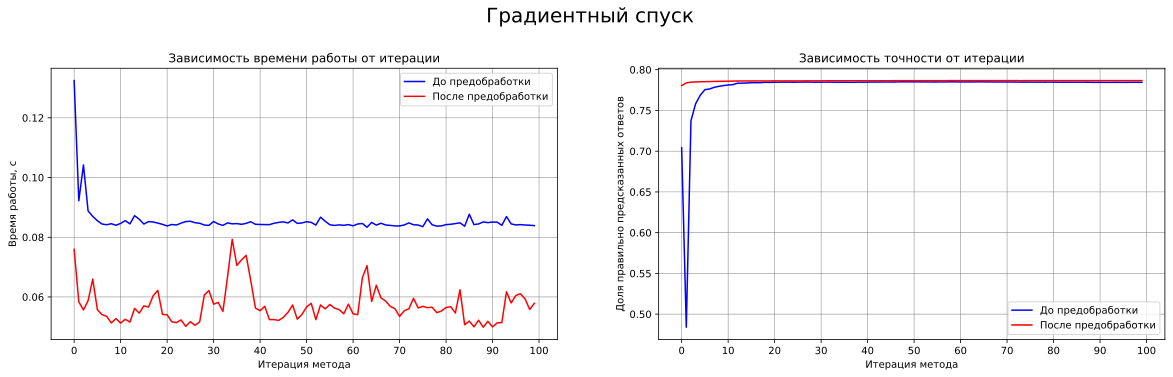

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Градиентный спуск', fontsize=20, y=1.05)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации')
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.plot(history_GDC_before['time'], color='blue', label='До предобработки')
plt.plot(history_GDC_after['time'], color='red', label='После предобработки')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title_fontsize=10, fontsize=10)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации')
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.plot(accuracy_GDC_before, color='blue', label='До предобработки')
plt.plot(accuracy_GDC_after, color='red', label='После предобработки')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title_fontsize=10, fontsize=10)

plt.savefig("TASK2 GDC before and after.pdf", bbox_inches = 'tight')
plt.show()

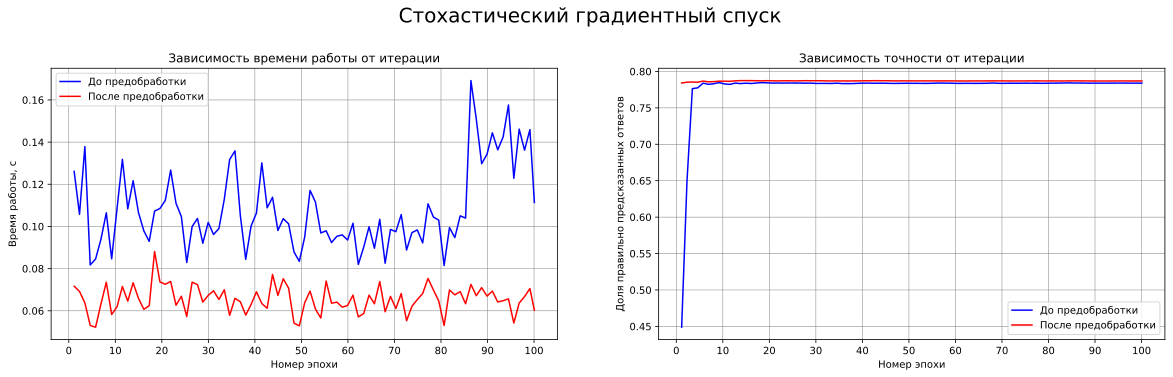

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Стохастический градиентный спуск', fontsize=20, y=1.05)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации')
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('Номер эпохи', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.plot(history_SGDC_before['epoch_num'],
         history_SGDC_before['time'], color='blue', label='До предобработки')
plt.plot(history_SGDC_after['epoch_num'],
         history_SGDC_after['time'], color='red', label='После предобработки')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title_fontsize=10, fontsize=10)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации')
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('Номер эпохи', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.plot(history_SGDC_before['epoch_num'],
         accuracy_SGDC_before, color='blue', label='До предобработки')
plt.plot(history_SGDC_after['epoch_num'],
         accuracy_SGDC_after, color='red', label='После предобработки')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title_fontsize=10, fontsize=10)

plt.savefig("TASK2 SGDC before and after.pdf", bbox_inches = 'tight')
plt.show()

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [69]:
vectorizer = TfidfVectorizer(min_df=0.0001)
X_train_Tfidf = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test_Tfidf = vectorizer.transform(test['comment_text'])

In [70]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
accuracy_GDC_Tfidf, history_GDC_Tfidf = clf.fit(
    X_train_Tfidf, y_train, w_0=np.full(X_train_Tfidf.shape[1], 0), trace=True, accuracy=True)

In [71]:
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
    step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
accuracy_SGDC_Tfidf, history_SGDC_Tfidf = clf.fit(
    X_train_Tfidf, y_train, w_0=np.full(X_train_Tfidf.shape[1], 0), trace=True, accuracy=True)

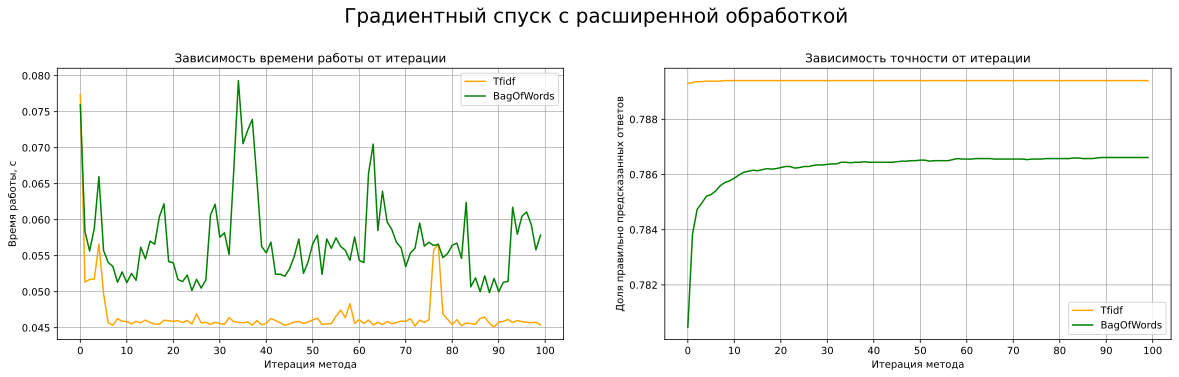

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Градиентный спуск с расширенной обработкой', fontsize=20, y=1.05)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации')
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.plot((history_GDC_Tfidf['time']), color='orange', label='Tfidf')
plt.plot((history_GDC_after['time']), color='green', label='BagOfWords')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title_fontsize=10, fontsize=10)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации')
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.plot((accuracy_GDC_Tfidf), color='orange', label='Tfidf')
plt.plot((accuracy_GDC_after), color='green', label='BagOfWords')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title_fontsize=10, fontsize=10)

plt.savefig("TASK2 GDC Tfidf.pdf", bbox_inches = 'tight')
plt.show()

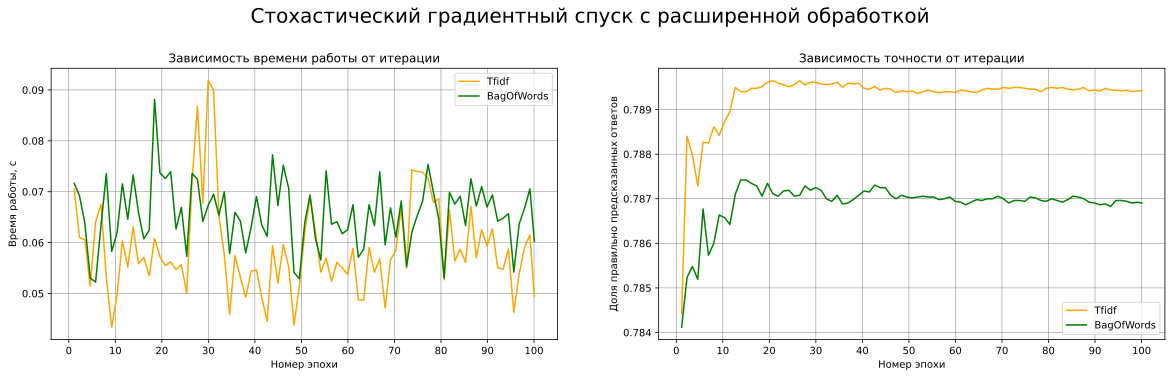

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Стохастический градиентный спуск с расширенной обработкой', fontsize=20, y=1.05)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации')
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('Номер эпохи', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.plot(history_SGDC_Tfidf['epoch_num'],
         history_SGDC_Tfidf['time'], color='orange', label='Tfidf')
plt.plot(history_SGDC_after['epoch_num'],
         history_SGDC_after['time'], color='green', label='BagOfWords')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title_fontsize=10, fontsize=10)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации')
plt.xticks(list(range(0, 110, 10)))
plt.xlabel('Номер эпохи', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.plot(history_SGDC_Tfidf['epoch_num'],
         accuracy_SGDC_Tfidf, color='orange', label='Tfidf')
plt.plot(history_SGDC_after['epoch_num'],
         accuracy_SGDC_after, color='green', label='BagOfWords')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title_fontsize=10, fontsize=10)

plt.savefig("TASK2 SGDC Tfidf.pdf", bbox_inches = 'tight')
plt.show()

In [74]:
parametrs_min_BOfW_SGD = dict.fromkeys(['accuracy', 'loss_func', 'epoch_num', 'time'])
parametrs_min_BOfW_SGD['accuracy'] = []
parametrs_min_BOfW_SGD['epoch_num'] = []
parametrs_min_BOfW_SGD['loss_func'] = []
parametrs_min_BOfW_SGD['time'] = []

parametrs_min_BOfW_GD = dict.fromkeys(['accuracy', 'loss_func', 'time'])
parametrs_min_BOfW_GD['accuracy'] = []
parametrs_min_BOfW_GD['loss_func'] = []
parametrs_min_BOfW_GD['time'] = []

parametrs_min_Tfidf_SGD = dict.fromkeys(['accuracy', 'loss_func', 'epoch_num', 'time'])
parametrs_min_Tfidf_SGD['accuracy'] = []
parametrs_min_Tfidf_SGD['epoch_num'] = []
parametrs_min_Tfidf_SGD['loss_func'] = []
parametrs_min_Tfidf_SGD['time'] = []

parametrs_min_Tfidf_GD = dict.fromkeys(['accuracy', 'loss_func', 'time'])
parametrs_min_Tfidf_GD['accuracy'] = []
parametrs_min_Tfidf_GD['loss_func'] = []
parametrs_min_Tfidf_GD['time'] = []

size_min_BOfW = []
size_min_Tfidf = []

for i in [0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1]:
    vectorizer = CountVectorizer(min_df=i)
    X_train_min = vectorizer.fit_transform(train['comment_text'])
    size_min_BOfW.append(X_train_min.shape[1])
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy_min_BOfW, history_min_BOfW = clf.fit(
        X_train_min, y_train, w_0=np.full(X_train_min.shape[1], 0), trace=True, accuracy=True)
    parametrs_min_BOfW_GD['accuracy'].append(accuracy_min_BOfW)
    parametrs_min_BOfW_GD['loss_func'].append(history_min_BOfW['func'])
    parametrs_min_BOfW_GD['time'].append(history_min_BOfW['time'])
    
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy_min_BOfW, history_min_BOfW = clf.fit(
        X_train_min, y_train, w_0=np.full(X_train_min.shape[1], 0), trace=True, accuracy=True)
    parametrs_min_BOfW_SGD['accuracy'].append(accuracy_min_BOfW)
    parametrs_min_BOfW_SGD['loss_func'].append(history_min_BOfW['func'])
    parametrs_min_BOfW_SGD['time'].append(history_min_BOfW['time'])
    parametrs_min_BOfW_SGD['epoch_num'].append(history_min_BOfW['epoch_num'])
    
    
    vectorizer = TfidfVectorizer(min_df=i)
    X_train_min = vectorizer.fit_transform(train['comment_text'])
    size_min_Tfidf.append(X_train_min.shape[1])
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy_min_Tfidf, history_min_Tfidf = clf.fit(
        X_train_min, y_train, w_0=np.full(X_train_min.shape[1], 0), trace=True, accuracy=True)
    parametrs_min_Tfidf_GD['accuracy'].append(accuracy_min_Tfidf)
    parametrs_min_Tfidf_GD['loss_func'].append(history_min_Tfidf['func'])
    parametrs_min_Tfidf_GD['time'].append(history_min_Tfidf['time'])
    
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy_min_Tfidf, history_min_Tfidf = clf.fit(
        X_train_min, y_train, w_0=np.full(X_train_min.shape[1], 0), trace=True, accuracy=True)
    parametrs_min_Tfidf_SGD['accuracy'].append(accuracy_min_Tfidf)
    parametrs_min_Tfidf_SGD['loss_func'].append(history_min_Tfidf['func'])
    parametrs_min_Tfidf_SGD['time'].append(history_min_Tfidf['time'])
    parametrs_min_Tfidf_SGD['epoch_num'].append(history_min_Tfidf['epoch_num'])

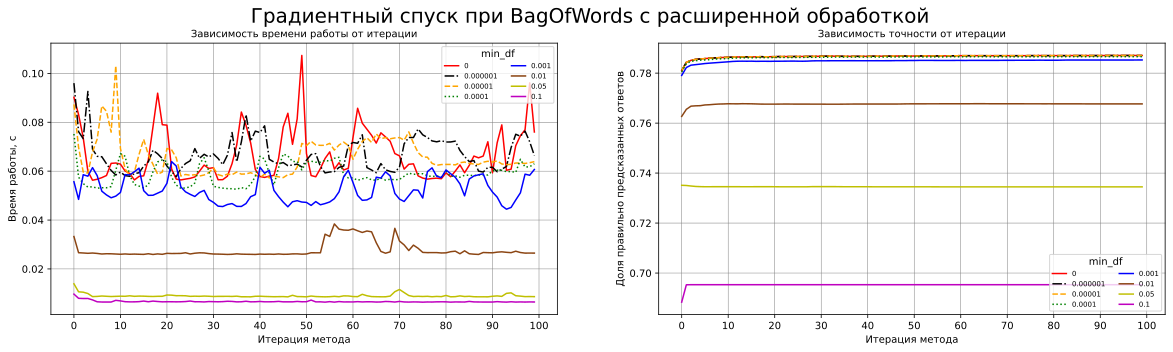

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Градиентный спуск при BagOfWords с расширенной обработкой', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_min_BOfW_GD['time'][0]), color='red', label='0', linestyle='-')
plt.plot((parametrs_min_BOfW_GD['time'][1]), color='black', label='0.000001', linestyle='-.')
plt.plot((parametrs_min_BOfW_GD['time'][2]), color='orange', label='0.00001', linestyle='--')
plt.plot((parametrs_min_BOfW_GD['time'][3]), color='green', label='0.0001', linestyle=':')
plt.plot((parametrs_min_BOfW_GD['time'][4]), color='b', label='0.001')
plt.plot((parametrs_min_BOfW_GD['time'][5]), color='saddlebrown', label='0.01', linestyle='-')
plt.plot((parametrs_min_BOfW_GD['time'][6]), color='y', label='0.05')
plt.plot((parametrs_min_BOfW_GD['time'][7]), color='m', label='0.1', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'min_df', title_fontsize=10, loc=1, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_min_BOfW_GD['accuracy'][0]), color='red', label='0', linestyle='-')
plt.plot((parametrs_min_BOfW_GD['accuracy'][1]), color='black', label='0.000001', linestyle='-.')
plt.plot((parametrs_min_BOfW_GD['accuracy'][2]), color='orange', label='0.00001', linestyle='--')
plt.plot((parametrs_min_BOfW_GD['accuracy'][3]), color='green', label='0.0001', linestyle=':')
plt.plot((parametrs_min_BOfW_GD['accuracy'][4]), color='b', label='0.001')
plt.plot((parametrs_min_BOfW_GD['accuracy'][5]), color='saddlebrown', label='0.01', linestyle='-')
plt.plot((parametrs_min_BOfW_GD['accuracy'][6]), color='y', label='0.05')
plt.plot((parametrs_min_BOfW_GD['accuracy'][7]), color='m', label='0.1', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'min_df', title_fontsize=10, loc=4, fontsize=7, ncol=2)

plt.savefig("TASK2 min_df BagOfWords GD.pdf", bbox_inches = 'tight')
plt.show()

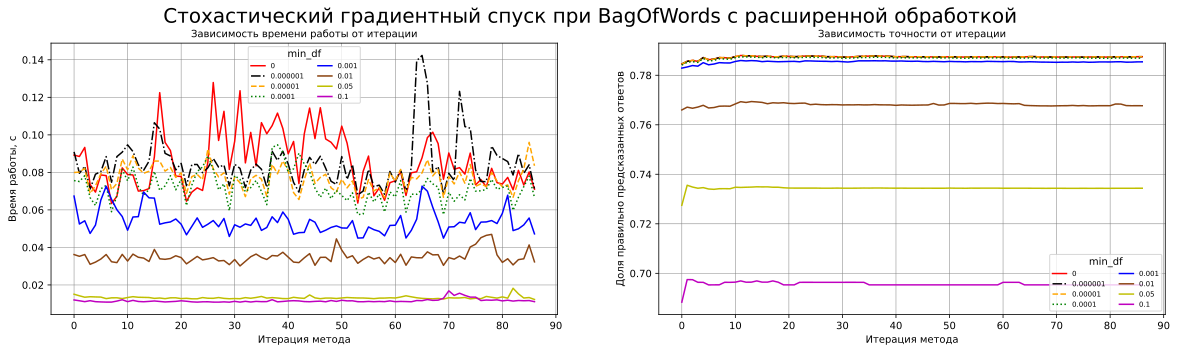

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Стохастический градиентный спуск при BagOfWords с расширенной обработкой', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_min_BOfW_SGD['time'][0]), color='red', label='0', linestyle='-')
plt.plot((parametrs_min_BOfW_SGD['time'][1]), color='black', label='0.000001', linestyle='-.')
plt.plot((parametrs_min_BOfW_SGD['time'][2]), color='orange', label='0.00001', linestyle='--')
plt.plot((parametrs_min_BOfW_SGD['time'][3]), color='green', label='0.0001', linestyle=':')
plt.plot((parametrs_min_BOfW_SGD['time'][4]), color='b', label='0.001')
plt.plot((parametrs_min_BOfW_SGD['time'][5]), color='saddlebrown', label='0.01', linestyle='-')
plt.plot((parametrs_min_BOfW_SGD['time'][6]), color='y', label='0.05')
plt.plot((parametrs_min_BOfW_SGD['time'][7]), color='m', label='0.1', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'min_df', title_fontsize=10, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_min_BOfW_SGD['accuracy'][0]), color='red', label='0', linestyle='-')
plt.plot((parametrs_min_BOfW_SGD['accuracy'][1]), color='black', label='0.000001', linestyle='-.')
plt.plot((parametrs_min_BOfW_SGD['accuracy'][2]), color='orange', label='0.00001', linestyle='--')
plt.plot((parametrs_min_BOfW_SGD['accuracy'][3]), color='green', label='0.0001', linestyle=':')
plt.plot((parametrs_min_BOfW_SGD['accuracy'][4]), color='b', label='0.001')
plt.plot((parametrs_min_BOfW_SGD['accuracy'][5]), color='saddlebrown', label='0.01', linestyle='-')
plt.plot((parametrs_min_BOfW_SGD['accuracy'][6]), color='y', label='0.05')
plt.plot((parametrs_min_BOfW_SGD['accuracy'][7]), color='m', label='0.1', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'min_df', title_fontsize=10, loc=4,fontsize=7, ncol=2)

plt.savefig("TASK2 min_df BagOfWords SGD.pdf", bbox_inches = 'tight')
plt.show()

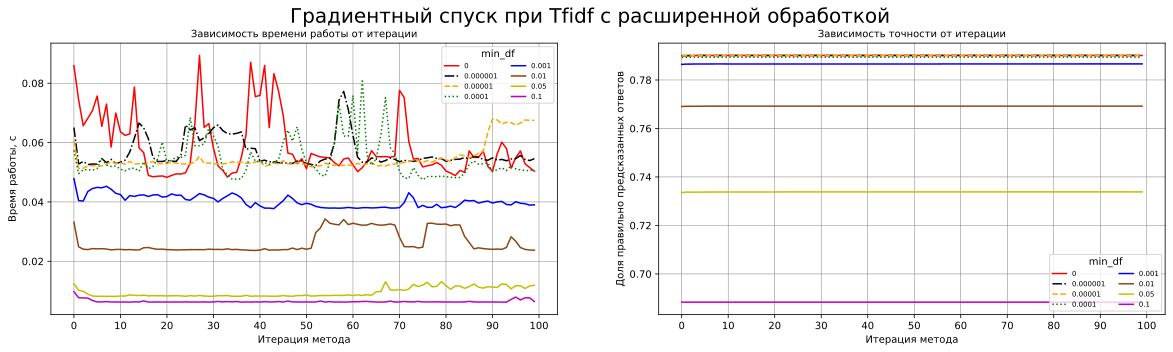

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Градиентный спуск при Tfidf с расширенной обработкой', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_min_Tfidf_GD['time'][0]), color='red', label='0', linestyle='-')
plt.plot((parametrs_min_Tfidf_GD['time'][1]), color='black', label='0.000001', linestyle='-.')
plt.plot((parametrs_min_Tfidf_GD['time'][2]), color='orange', label='0.00001', linestyle='--')
plt.plot((parametrs_min_Tfidf_GD['time'][3]), color='green', label='0.0001', linestyle=':')
plt.plot((parametrs_min_Tfidf_GD['time'][4]), color='b', label='0.001')
plt.plot((parametrs_min_Tfidf_GD['time'][5]), color='saddlebrown', label='0.01', linestyle='-')
plt.plot((parametrs_min_Tfidf_GD['time'][6]), color='y', label='0.05')
plt.plot((parametrs_min_Tfidf_GD['time'][7]), color='m', label='0.1', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'min_df', title_fontsize=10, loc=1, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_min_Tfidf_GD['accuracy'][0]), color='red', label='0', linestyle='-')
plt.plot((parametrs_min_Tfidf_GD['accuracy'][1]), color='black', label='0.000001', linestyle='-.')
plt.plot((parametrs_min_Tfidf_GD['accuracy'][2]), color='orange', label='0.00001', linestyle='--')
plt.plot((parametrs_min_Tfidf_GD['accuracy'][3]), color='green', label='0.0001', linestyle=':')
plt.plot((parametrs_min_Tfidf_GD['accuracy'][4]), color='b', label='0.001')
plt.plot((parametrs_min_Tfidf_GD['accuracy'][5]), color='saddlebrown', label='0.01', linestyle='-')
plt.plot((parametrs_min_Tfidf_GD['accuracy'][6]), color='y', label='0.05')
plt.plot((parametrs_min_Tfidf_GD['accuracy'][7]), color='m', label='0.1', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'min_df', title_fontsize=10, loc=4, fontsize=7, ncol=2)

plt.savefig("TASK2 min_df Tfidf GD.pdf", bbox_inches = 'tight')
plt.show()

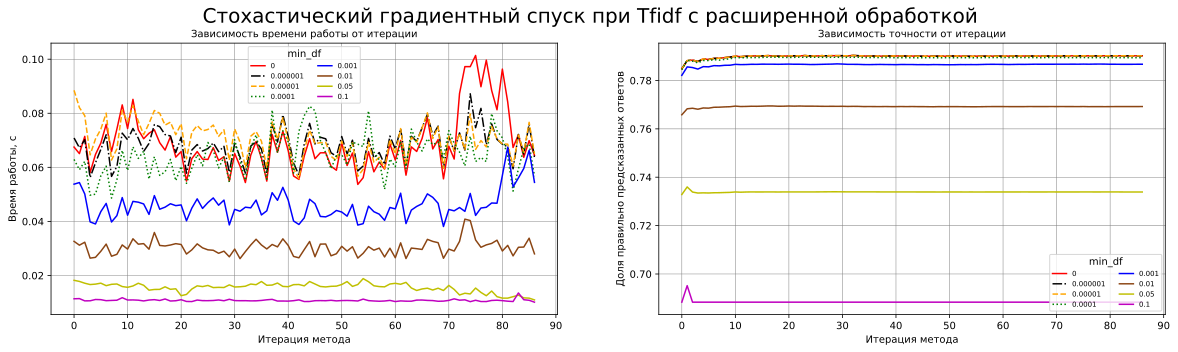

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Стохастический градиентный спуск при Tfidf с расширенной обработкой', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_min_Tfidf_SGD['time'][0]), color='red', label='0', linestyle='-')
plt.plot((parametrs_min_Tfidf_SGD['time'][1]), color='black', label='0.000001', linestyle='-.')
plt.plot((parametrs_min_Tfidf_SGD['time'][2]), color='orange', label='0.00001', linestyle='--')
plt.plot((parametrs_min_Tfidf_SGD['time'][3]), color='green', label='0.0001', linestyle=':')
plt.plot((parametrs_min_Tfidf_SGD['time'][4]), color='b', label='0.001')
plt.plot((parametrs_min_Tfidf_SGD['time'][5]), color='saddlebrown', label='0.01', linestyle='-')
plt.plot((parametrs_min_Tfidf_SGD['time'][6]), color='y', label='0.05')
plt.plot((parametrs_min_Tfidf_SGD['time'][7]), color='m', label='0.1', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'min_df', title_fontsize=10, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_min_Tfidf_SGD['accuracy'][0]), color='red', label='0', linestyle='-')
plt.plot((parametrs_min_Tfidf_SGD['accuracy'][1]), color='black', label='0.000001', linestyle='-.')
plt.plot((parametrs_min_Tfidf_SGD['accuracy'][2]), color='orange', label='0.00001', linestyle='--')
plt.plot((parametrs_min_Tfidf_SGD['accuracy'][3]), color='green', label='0.0001', linestyle=':')
plt.plot((parametrs_min_Tfidf_SGD['accuracy'][4]), color='b', label='0.001')
plt.plot((parametrs_min_Tfidf_SGD['accuracy'][5]), color='saddlebrown', label='0.01', linestyle='-')
plt.plot((parametrs_min_Tfidf_SGD['accuracy'][6]), color='y', label='0.05')
plt.plot((parametrs_min_Tfidf_SGD['accuracy'][7]), color='m', label='0.1', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'min_df', loc=4, title_fontsize=10, fontsize=7, ncol=2)

plt.savefig("TASK2 min_df Tfidf SGD.pdf", bbox_inches = 'tight')
plt.show()

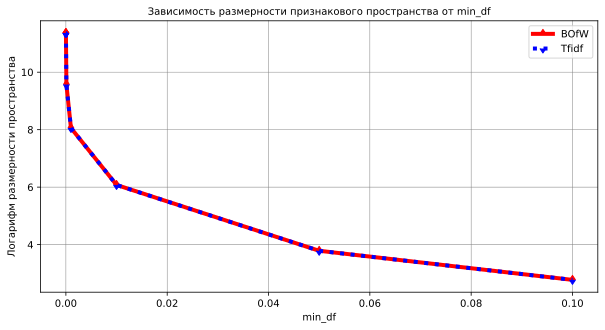

In [79]:
fig, ax = plt.subplots(figsize=(10,5))

plt.title('Зависимость размерности признакового пространства от min_df', fontsize=10)
plt.xlabel('min_df', fontsize=10)
plt.ylabel('Логарифм размерности пространства', fontsize=10)
plt.plot([0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1], np.log(size_min_BOfW), 
         color='red', label='BOfW', linestyle='-', marker=10, linewidth=4)
plt.plot([0, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1], np.log(size_min_Tfidf), 
         color='blue', label='Tfidf', linestyle=':', marker=11, linewidth=4)
plt.legend(title_fontsize=15, fontsize=10)
plt.grid(which='major', color = 'grey', linewidth = 0.5)

plt.savefig("TASK2 min_df size.pdf", bbox_inches = 'tight')
plt.show()

In [80]:
parametrs_max_BOfW_SGD = dict.fromkeys(['accuracy', 'loss_func', 'epoch_num', 'time'])
parametrs_max_BOfW_SGD['accuracy'] = []
parametrs_max_BOfW_SGD['epoch_num'] = []
parametrs_max_BOfW_SGD['loss_func'] = []
parametrs_max_BOfW_SGD['time'] = []

parametrs_max_BOfW_GD = dict.fromkeys(['accuracy', 'loss_func', 'time'])
parametrs_max_BOfW_GD['accuracy'] = []
parametrs_max_BOfW_GD['loss_func'] = []
parametrs_max_BOfW_GD['time'] = []

parametrs_max_Tfidf_SGD = dict.fromkeys(['accuracy', 'loss_func', 'epoch_num', 'time'])
parametrs_max_Tfidf_SGD['accuracy'] = []
parametrs_max_Tfidf_SGD['epoch_num'] = []
parametrs_max_Tfidf_SGD['loss_func'] = []
parametrs_max_Tfidf_SGD['time'] = []

parametrs_max_Tfidf_GD = dict.fromkeys(['accuracy', 'loss_func', 'time'])
parametrs_max_Tfidf_GD['accuracy'] = []
parametrs_max_Tfidf_GD['loss_func'] = []
parametrs_max_Tfidf_GD['time'] = []

size_max_BOfW = []
size_max_Tfidf = []

lst = [1.0, 0.2, 0.1, 0.05, 0.001, 0.0005, 0.0001, 0.00005]

for i in lst:
    vectorizer = CountVectorizer(max_df=i)
    X_train_max = vectorizer.fit_transform(train['comment_text'])
    size_max_BOfW.append(X_train_max.shape[1])
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy_max_BOfW, history_max_BOfW = clf.fit(
        X_train_max, y_train, w_0=np.full(X_train_max.shape[1], 0), trace=True, accuracy=True)
    parametrs_max_BOfW_GD['accuracy'].append(accuracy_max_BOfW)
    parametrs_max_BOfW_GD['loss_func'].append(history_max_BOfW['func'])
    parametrs_max_BOfW_GD['time'].append(history_max_BOfW['time'])
    
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy_max_BOfW, history_max_BOfW = clf.fit(
        X_train_max, y_train, w_0=np.full(X_train_max.shape[1], 0), trace=True, accuracy=True)
    parametrs_max_BOfW_SGD['accuracy'].append(accuracy_max_BOfW)
    parametrs_max_BOfW_SGD['loss_func'].append(history_max_BOfW['func'])
    parametrs_max_BOfW_SGD['time'].append(history_max_BOfW['time'])
    parametrs_max_BOfW_SGD['epoch_num'].append(history_max_BOfW['epoch_num'])
    
    
    vectorizer = TfidfVectorizer(max_df=i)
    X_train_max = vectorizer.fit_transform(train['comment_text'])
    size_max_Tfidf.append(X_train_max.shape[1])
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy_max_Tfidf, history_max_Tfidf = clf.fit(
        X_train_max, y_train, w_0=np.full(X_train_max.shape[1], 0), trace=True, accuracy=True)
    parametrs_max_Tfidf_GD['accuracy'].append(accuracy_max_Tfidf)
    parametrs_max_Tfidf_GD['loss_func'].append(history_max_Tfidf['func'])
    parametrs_max_Tfidf_GD['time'].append(history_max_Tfidf['time'])
    
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
        step_beta=1.1, tolerance=0, max_iter=100, l2_coef=1)
    accuracy_max_Tfidf, history_max_Tfidf = clf.fit(
        X_train_max, y_train, w_0=np.full(X_train_max.shape[1], 0), trace=True, accuracy=True)
    parametrs_max_Tfidf_SGD['accuracy'].append(accuracy_max_Tfidf)
    parametrs_max_Tfidf_SGD['loss_func'].append(history_max_Tfidf['func'])
    parametrs_max_Tfidf_SGD['time'].append(history_max_Tfidf['time'])
    parametrs_max_Tfidf_SGD['epoch_num'].append(history_max_Tfidf['epoch_num'])

In [613]:
lst

array([1.      , 0.999999, 0.99999 , 0.9999  , 0.999   , 0.99    ,
       0.95    , 0.9     ])

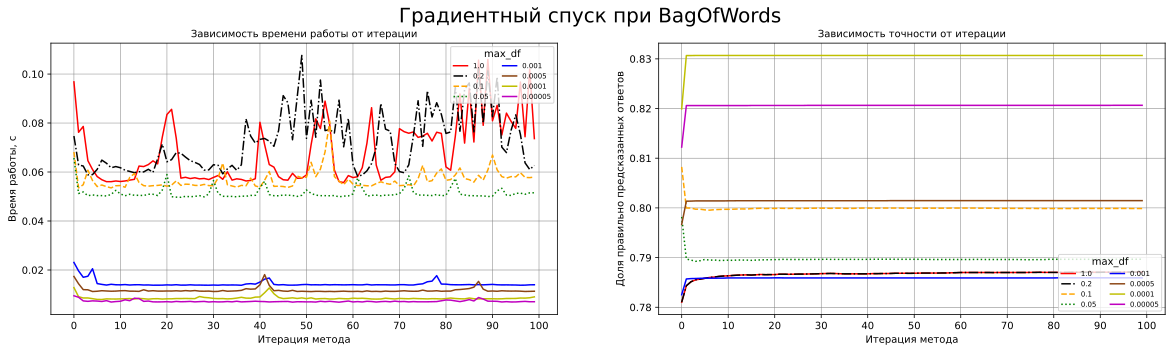

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Градиентный спуск при BagOfWords', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_max_BOfW_GD['time'][0]), color='red', label='1.0', linestyle='-')
plt.plot((parametrs_max_BOfW_GD['time'][1]), color='black', label='0.2', linestyle='-.')
plt.plot((parametrs_max_BOfW_GD['time'][2]), color='orange', label='0.1', linestyle='--')
plt.plot((parametrs_max_BOfW_GD['time'][3]), color='green', label='0.05', linestyle=':')
plt.plot((parametrs_max_BOfW_GD['time'][4]), color='b', label='0.001')
plt.plot((parametrs_max_BOfW_GD['time'][5]), color='saddlebrown', label='0.0005', linestyle='-')
plt.plot((parametrs_max_BOfW_GD['time'][6]), color='y', label='0.0001')
plt.plot((parametrs_max_BOfW_GD['time'][7]), color='m', label='0.00005', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'max_df', title_fontsize=10, loc=1, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_max_BOfW_GD['accuracy'][0]), color='red', label='1.0', linestyle='-')
plt.plot((parametrs_max_BOfW_GD['accuracy'][1]), color='black', label='0.2', linestyle='-.')
plt.plot((parametrs_max_BOfW_GD['accuracy'][2]), color='orange', label='0.1', linestyle='--')
plt.plot((parametrs_max_BOfW_GD['accuracy'][3]), color='green', label='0.05', linestyle=':')
plt.plot((parametrs_max_BOfW_GD['accuracy'][4]), color='b', label='0.001')
plt.plot((parametrs_max_BOfW_GD['accuracy'][5]), color='saddlebrown', label='0.0005', linestyle='-')
plt.plot((parametrs_max_BOfW_GD['accuracy'][6]), color='y', label='0.0001')
plt.plot((parametrs_max_BOfW_GD['accuracy'][7]), color='m', label='0.00005', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'max_df', title_fontsize=10, loc=4, fontsize=7, ncol=2)

plt.savefig("TASK2 max_df BagOfWords GD.pdf", bbox_inches = 'tight')
plt.show()

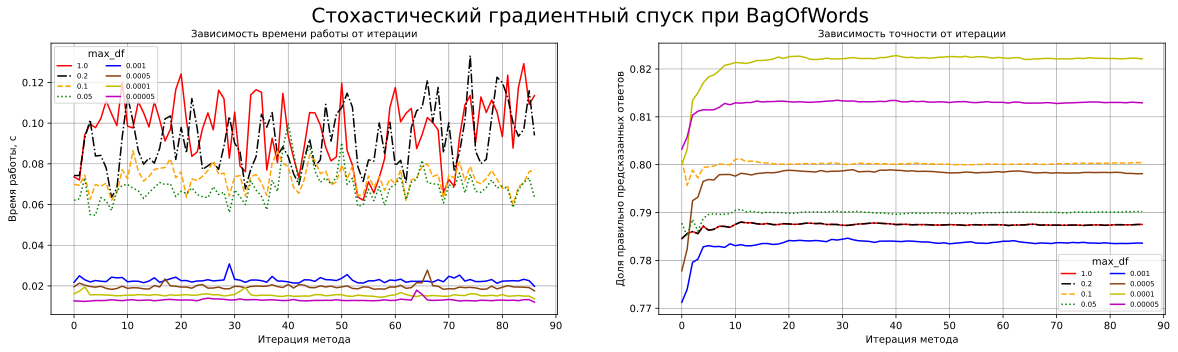

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Стохастический градиентный спуск при BagOfWords', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_max_BOfW_SGD['time'][0]), color='red', label='1.0', linestyle='-')
plt.plot((parametrs_max_BOfW_SGD['time'][1]), color='black', label='0.2', linestyle='-.')
plt.plot((parametrs_max_BOfW_SGD['time'][2]), color='orange', label='0.1', linestyle='--')
plt.plot((parametrs_max_BOfW_SGD['time'][3]), color='green', label='0.05', linestyle=':')
plt.plot((parametrs_max_BOfW_SGD['time'][4]), color='b', label='0.001')
plt.plot((parametrs_max_BOfW_SGD['time'][5]), color='saddlebrown', label='0.0005', linestyle='-')
plt.plot((parametrs_max_BOfW_SGD['time'][6]), color='y', label='0.0001')
plt.plot((parametrs_max_BOfW_SGD['time'][7]), color='m', label='0.00005', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'max_df', title_fontsize=10, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_max_BOfW_SGD['accuracy'][0]), color='red', label='1.0', linestyle='-')
plt.plot((parametrs_max_BOfW_SGD['accuracy'][1]), color='black', label='0.2', linestyle='-.')
plt.plot((parametrs_max_BOfW_SGD['accuracy'][2]), color='orange', label='0.1', linestyle='--')
plt.plot((parametrs_max_BOfW_SGD['accuracy'][3]), color='green', label='0.05', linestyle=':')
plt.plot((parametrs_max_BOfW_SGD['accuracy'][4]), color='b', label='0.001')
plt.plot((parametrs_max_BOfW_SGD['accuracy'][5]), color='saddlebrown', label='0.0005', linestyle='-')
plt.plot((parametrs_max_BOfW_SGD['accuracy'][6]), color='y', label='0.0001')
plt.plot((parametrs_max_BOfW_SGD['accuracy'][7]), color='m', label='0.00005', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'max_df', title_fontsize=10, loc=4,fontsize=7, ncol=2)

plt.savefig("TASK2 max_df BagOfWords SGD.pdf", bbox_inches = 'tight')
plt.show()

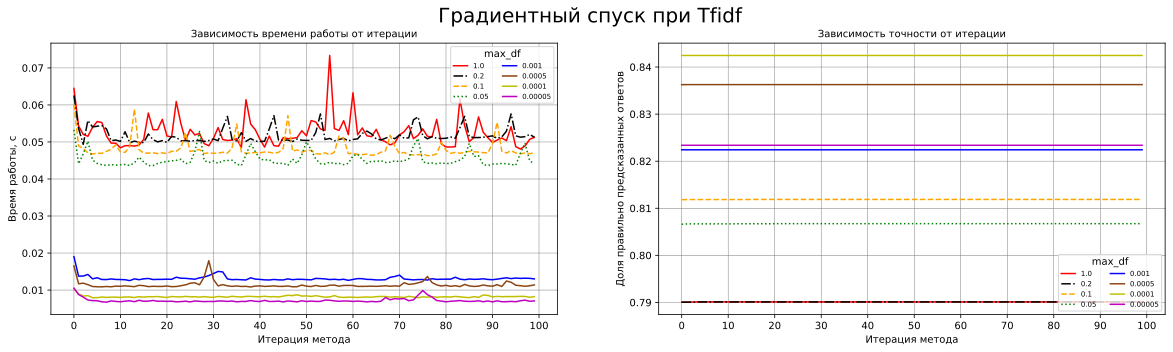

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Градиентный спуск при Tfidf', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_max_Tfidf_GD['time'][0]), color='red', label='1.0', linestyle='-')
plt.plot((parametrs_max_Tfidf_GD['time'][1]), color='black', label='0.2', linestyle='-.')
plt.plot((parametrs_max_Tfidf_GD['time'][2]), color='orange', label='0.1', linestyle='--')
plt.plot((parametrs_max_Tfidf_GD['time'][3]), color='green', label='0.05', linestyle=':')
plt.plot((parametrs_max_Tfidf_GD['time'][4]), color='b', label='0.001')
plt.plot((parametrs_max_Tfidf_GD['time'][5]), color='saddlebrown', label='0.0005', linestyle='-')
plt.plot((parametrs_max_Tfidf_GD['time'][6]), color='y', label='0.0001')
plt.plot((parametrs_max_Tfidf_GD['time'][7]), color='m', label='0.00005', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'max_df', title_fontsize=10, loc=1, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_max_Tfidf_GD['accuracy'][0]), color='red', label='1.0', linestyle='-')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][1]), color='black', label='0.2', linestyle='-.')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][2]), color='orange', label='0.1', linestyle='--')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][3]), color='green', label='0.05', linestyle=':')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][4]), color='b', label='0.001')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][5]), color='saddlebrown', label='0.0005', linestyle='-')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][6]), color='y', label='0.0001')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][7]), color='m', label='0.00005', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'max_df', title_fontsize=10, loc=4, fontsize=7, ncol=2)

plt.savefig("TASK2 max_df Tfidf GD.pdf", bbox_inches = 'tight')
plt.show()

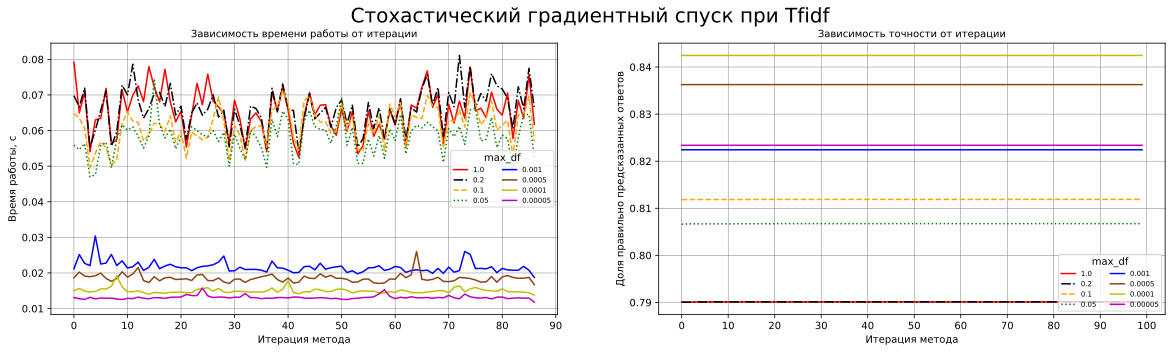

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Стохастический градиентный спуск при Tfidf', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_max_Tfidf_SGD['time'][0]), color='red', label='1.0', linestyle='-')
plt.plot((parametrs_max_Tfidf_SGD['time'][1]), color='black', label='0.2', linestyle='-.')
plt.plot((parametrs_max_Tfidf_SGD['time'][2]), color='orange', label='0.1', linestyle='--')
plt.plot((parametrs_max_Tfidf_SGD['time'][3]), color='green', label='0.05', linestyle=':')
plt.plot((parametrs_max_Tfidf_SGD['time'][4]), color='b', label='0.001')
plt.plot((parametrs_max_Tfidf_SGD['time'][5]), color='saddlebrown', label='0.0005', linestyle='-')
plt.plot((parametrs_max_Tfidf_SGD['time'][6]), color='y', label='0.0001')
plt.plot((parametrs_max_Tfidf_SGD['time'][7]), color='m', label='0.00005', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'max_df', title_fontsize=10, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_max_Tfidf_GD['accuracy'][0]), color='red', label='1.0', linestyle='-')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][1]), color='black', label='0.2', linestyle='-.')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][2]), color='orange', label='0.1', linestyle='--')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][3]), color='green', label='0.05', linestyle=':')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][4]), color='b', label='0.001')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][5]), color='saddlebrown', label='0.0005', linestyle='-')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][6]), color='y', label='0.0001')
plt.plot((parametrs_max_Tfidf_GD['accuracy'][7]), color='m', label='0.00005', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'max_df', loc=4, title_fontsize=10, fontsize=7, ncol=2)

plt.savefig("TASK2 max_df Tfidf SGD.pdf", bbox_inches = 'tight')
plt.show()

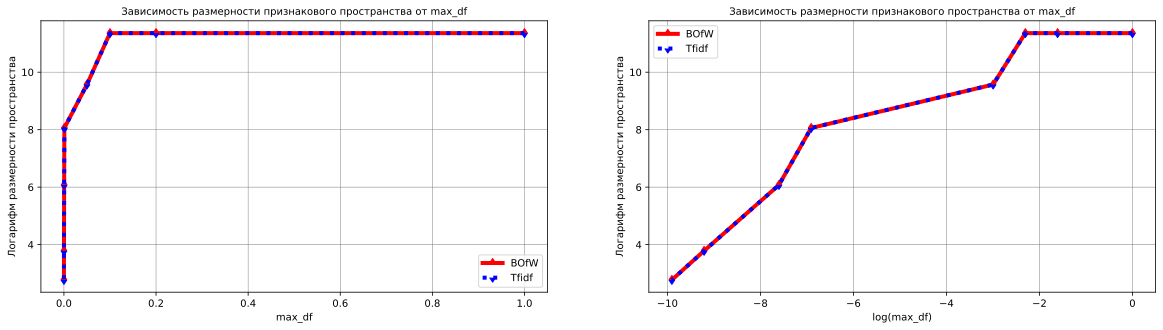

In [85]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Зависимость размерности признакового пространства от max_df', fontsize=10)
plt.xlabel('max_df', fontsize=10)
plt.ylabel('Логарифм размерности пространства', fontsize=10)
plt.plot((lst), np.log(size_min_BOfW), 
         color='red', label='BOfW', linestyle='-', marker=10, linewidth=4)
plt.plot((lst), np.log(size_min_Tfidf), 
         color='blue', label='Tfidf', linestyle=':', marker=11, linewidth=4)
plt.legend(title_fontsize=15, fontsize=10)
plt.grid(which='major', color = 'grey', linewidth = 0.5)


plt.subplot(1, 2, 2)
plt.title('Зависимость размерности признакового пространства от max_df', fontsize=10)
plt.xlabel('log(max_df)', fontsize=10)
plt.ylabel('Логарифм размерности пространства', fontsize=10)
plt.plot(np.log(lst), np.log(size_min_BOfW), 
         color='red', label='BOfW', linestyle='-', marker=10, linewidth=4)
plt.plot(np.log(lst), np.log(size_min_Tfidf), 
         color='blue', label='Tfidf', linestyle=':', marker=11, linewidth=4)
plt.legend(title_fontsize=15, fontsize=10)
plt.grid(which='major', color = 'grey', linewidth = 0.5)

plt.savefig("TASK2 max_df size.pdf", bbox_inches = 'tight')
plt.show()

Выберите лучший алгоритм для тестовой выборки.Проанализируйт еошибки алгоритма.Проанализируйте и укажите общие черты объектов, на которых были допущены ошибки.

    max_df = 0.0001, min_df = 0.00005, обработка, TFIDF

In [140]:
vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.0001)
X_train_last = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test_last = vectorizer.transform(test['comment_text'])

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [87]:
X_train_last.shape

(52061, 9842)

In [88]:
X_test_last.shape

(20676, 9842)

In [89]:
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=1e-5, max_iter=10000, l2_coef=1)
clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True);

In [90]:
pred_test = clf.predict(X_test_last)

In [91]:
pred_test

array([1, 1, 1, ..., 1, 1, 1])

In [92]:
np.sum(pred_test == y_test) / len(y_test)

0.6958792803250146

In [93]:
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
    step_beta=1.1, tolerance=1e-5, max_iter=10000, l2_coef=1)
clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True);

In [94]:
pred_test = clf.predict(X_test_last)

In [95]:
np.sum(pred_test == y_test) / len(y_test)

0.688479396401625

In [141]:
vectorizer = TfidfVectorizer(min_df=0.0001)
X_train_last = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test_last = vectorizer.transform(test['comment_text'])
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=1e-5, max_iter=10000, l2_coef=1)
clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True);
pred_test = clf.predict(X_test_last)
print(np.sum(pred_test == y_test) / len(y_test))
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
    step_beta=1.1, tolerance=1e-5, max_iter=10000, l2_coef=1)
clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True);
pred_test = clf.predict(X_test_last)
print(np.sum(pred_test == y_test) / len(y_test))

0.8159218417488876
0.8138421358096344


In [136]:
vectorizer = TfidfVectorizer(max_df=0.0001)
X_train_last = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test_last = vectorizer.transform(test['comment_text'])
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=1e-5, max_iter=10000, l2_coef=1)
clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True);
pred_test = clf.predict(X_test_last)
print(np.sum(pred_test == y_test) / len(y_test))
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
    step_beta=1.1, tolerance=1e-5, max_iter=10000, l2_coef=1)
clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True);
pred_test = clf.predict(X_test_last)
print(np.sum(pred_test == y_test) / len(y_test))

0.690075449796866
0.6809827819694332


In [138]:
vectorizer = TfidfVectorizer(max_df=0.00005)
X_train_last = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test_last = vectorizer.transform(test['comment_text'])
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
    step_beta=1.1, tolerance=1e-5, max_iter=10000, l2_coef=1)
clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True);
pred_test = clf.predict(X_test_last)
print(np.sum(pred_test == y_test) / len(y_test))
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.5, batch_size=10000,
    step_beta=1.1, tolerance=1e-5, max_iter=10000, l2_coef=1)
clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True);
pred_test = clf.predict(X_test_last)
print(np.sum(pred_test == y_test) / len(y_test))

0.6822402785838654
0.6790965370477848


In [704]:
test

Unnamed: 0                                       comment_text  is_toxic
0               0  thank understanding think highly would revert ...     False
1               1                            dear god site horrible      False
2               2   somebody invariably try add religion really m...     False
3               3   say right type type institution need case thr...     False
4               4   add new product list make sure relevant add n...     False
...           ...                                                ...       ...
20671       63877                                 nigel crazy idiot       True
20672       63935                                  well feel stupid       True
20673       63945   fourth baldrick possibly clever make anyone e...      True
20674       63962   iran right iran drone spread homosexual weste...      True
20675       63976  mel gibson nazi bitch make shitty movies much ...      True

[20676 rows x 3 columns]

In [715]:
test_orig = pd.read_csv("/Users/polinakrivula/Downloads/data_toxic/toxic_test.csv")

Unnamed: 0                                       comment_text  is_toxic
8               8   arab commit genocide iraq protest europe may ...      True
30             30                                   puwersa ng masa      False
38             38     dare vandalize page hm beagle vandalize demon       True
79             79                                        hell justin     False
87             87   buffoon synonyms bozo buffo clown comedian co...     False
...           ...                                                ...       ...
20670       63865   sorry dickhead cannae help douche bag dumbass...      True
20672       63935                                  well feel stupid       True
20673       63945   fourth baldrick possibly clever make anyone e...      True
20674       63962   iran right iran drone spread homosexual weste...      True
20675       63976  mel gibson nazi bitch make shitty movies much ...      True

[3849 rows x 3 columns]

In [714]:
test_orig[y_test != pred_test]

Unnamed: 0                                       comment_text  is_toxic
8               8  == Arabs are committing genocide in Iraq, but ...      True
30             30                                   Puwersa ng Masa!     False
38             38  How dare you vandalize that page about the HMS...      True
79             79                        WHAT THE HELL \n\n   Justin     False
87             87  ::::Buffoon Synonyms:    bozo, buffo, clown, c...     False
...           ...                                                ...       ...
20670       63865  am sorry for being a dickhead! I cannae help i...      True
20672       63935    " \n ::Well, now don't I feel stupid....   ·  "      True
20673       63945  ==Fourth Baldrick possibly being cleverer than...      True
20674       63962  " \n\n == IRAN == \n That’s right, Iran. It wa...      True
20675       63976  MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...      True

[3849 rows x 3 columns]

In [716]:
test[y_test != pred_test]

Unnamed: 0                                       comment_text  is_toxic
8               8   arab commit genocide iraq protest europe may ...      True
30             30                                   puwersa ng masa      False
38             38     dare vandalize page hm beagle vandalize demon       True
79             79                                        hell justin     False
87             87   buffoon synonyms bozo buffo clown comedian co...     False
...           ...                                                ...       ...
20670       63865   sorry dickhead cannae help douche bag dumbass...      True
20672       63935                                  well feel stupid       True
20673       63945   fourth baldrick possibly clever make anyone e...      True
20674       63962   iran right iran drone spread homosexual weste...      True
20675       63976  mel gibson nazi bitch make shitty movies much ...      True

[3849 rows x 3 columns]

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
M = confusion_matrix(y_test, pred_test)

In [143]:
M

array([[ 2743,  3500],
       [  349, 14084]])

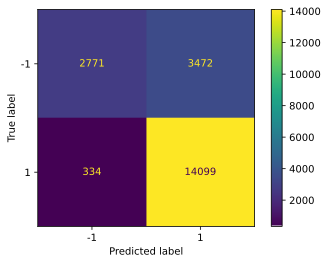

In [134]:
disp = ConfusionMatrixDisplay(confusion_matrix=M,
                            display_labels=[-1, 1])
disp.plot()
disp.figure_.savefig('conf_mat.pdf',dpi=300)
plt.show()

n-gram. Работаем с GDClassifier

In [98]:
parametrs_GD_ngram = dict.fromkeys(['accuracy', 'time'])
parametrs_GD_ngram['accuracy'] = []
parametrs_GD_ngram['time'] = []
n_grams = [1, 2, 3, 5, 8, 10, 13, 15]
res_test = []

for i in n_grams:
    vectorizer = TfidfVectorizer(min_df=0.00005, ngram_range=(1, i))
    X_train_last = vectorizer.fit_transform(train['comment_text'])
    vectorizer.fit(train['comment_text'])
    X_test_last = vectorizer.transform(test['comment_text'])
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
        step_beta=1.1, tolerance=0, max_iter=1000, l2_coef=1)
    accuracy, history = clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True)
    parametrs_GD_ngram['accuracy'].append(accuracy)
    parametrs_GD_ngram['time'].append(history['time'])
    pred_test = clf.predict(X_test_last)
    r = np.sum(pred_test == y_test) / len(y_test)
    print(r)
    res_test.append(r)

0.8155349197136776
0.8162603985296962
0.8167440510737086
0.8172760688721222
0.8177113561617334
0.8178080866705358
0.8179531824337396
0.818049912942542


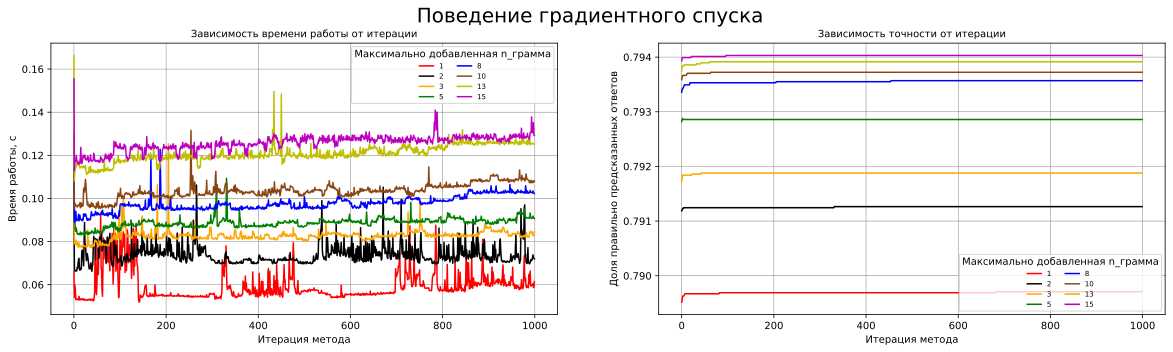

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
plt.suptitle('Поведение градиентного спуска', fontsize=20)

plt.subplot(1, 2, 1)
plt.title('Зависимость времени работы от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Время работы, с', fontsize=10)
#plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_GD_ngram['time'][0]), color='red', label='1', linestyle='-')
plt.plot((parametrs_GD_ngram['time'][1]), color='black', label='2', linestyle='-')
plt.plot((parametrs_GD_ngram['time'][2]), color='orange', label='3', linestyle='-')
plt.plot((parametrs_GD_ngram['time'][3]), color='green', label='5', linestyle='-')
plt.plot((parametrs_GD_ngram['time'][4]), color='b', label='8')
plt.plot((parametrs_GD_ngram['time'][5]), color='saddlebrown', label='10', linestyle='-')
plt.plot((parametrs_GD_ngram['time'][6]), color='y', label='13')
plt.plot((parametrs_GD_ngram['time'][7]), color='m', label='15', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'Максимально добавленная n_грамма', title_fontsize=10, loc=1, fontsize=7, ncol=2)

plt.subplot(1, 2, 2)
plt.title('Зависимость точности от итерации', fontsize=10)
plt.xlabel('Итерация метода', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
#plt.xticks(list(range(0, 110, 10)))
plt.plot((parametrs_GD_ngram['accuracy'][0]), color='red', label='1', linestyle='-')
plt.plot((parametrs_GD_ngram['accuracy'][1]), color='black', label='2', linestyle='-')
plt.plot((parametrs_GD_ngram['accuracy'][2]), color='orange', label='3', linestyle='-')
plt.plot((parametrs_GD_ngram['accuracy'][3]), color='green', label='5', linestyle='-')
plt.plot((parametrs_GD_ngram['accuracy'][4]), color='b', label='8')
plt.plot((parametrs_GD_ngram['accuracy'][5]), color='saddlebrown', label='10', linestyle='-')
plt.plot((parametrs_GD_ngram['accuracy'][6]), color='y', label='13')
plt.plot((parametrs_GD_ngram['accuracy'][7]), color='m', label='15', linestyle='-')
plt.grid(which='major', color = 'grey', linewidth = 0.5)
plt.legend(title = 'Максимально добавленная n_грамма', title_fontsize=10, loc=4, fontsize=7, ncol=2)

plt.savefig("TASK2 n_gram.pdf", bbox_inches = 'tight')
plt.show()

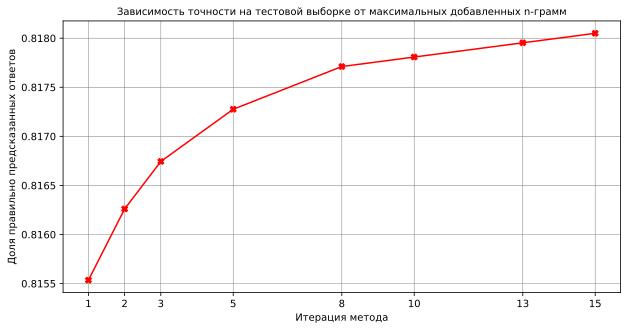

In [110]:
fig, ax = plt.subplots(figsize=(10,5))

plt.title('Зависимость точности на тестовой выборке от максимальных добавленных n-грамм', fontsize=10)
plt.xlabel('Максимально добавленная n-грамма', fontsize=10)
plt.ylabel('Доля правильно предсказанных ответов', fontsize=10)
plt.xticks(n_grams)
#plt.xticks(list(range(0, 110, 10)))
plt.plot(n_grams, res_test, color='red', label='1', linestyle='-', marker='X')
plt.grid(which='major', color = 'grey', linewidth = 0.5)

plt.savefig("TASK2 n_gram test.pdf", bbox_inches = 'tight')
plt.show()

In [169]:
train = pd.read_csv("/Users/polinakrivula/Downloads/data_toxic/toxic_train.csv")
test = pd.read_csv("/Users/polinakrivula/Downloads/data_toxic/toxic_test.csv")
train['comment_text'] = train.comment_text.str.lower()
test['comment_text'] = test.comment_text.str.lower()
for i in range(0, train.shape[0]):
    train['comment_text'][i] = simple_lemmatizer(train['comment_text'][i])
for i in range(0, test.shape[0]):
    test['comment_text'][i] = simple_lemmatizer(test['comment_text'][i])
# здесь удаляем стоп-слова
pat = r'\b(?:{})\b'.format('|'.join(stop))
train['comment_text'] = train['comment_text'].str.replace(pat, '')
train['comment_text'] = train['comment_text'].str.replace(r'\s+', ' ')
test['comment_text'] = test['comment_text'].str.replace(pat, '')
test['comment_text'] = test['comment_text'].str.replace(r'\s+', ' ')
# здесь удаляем все что осталось кроме букв и цифр и воскл. знаков
train['comment_text'] = train.comment_text.str.replace('[^a-zа-яё0-9!]', ' ')
train['comment_text'] = train.comment_text.str.replace(' +', ' ')
test['comment_text'] = test.comment_text.str.replace('[^a-zа-яё0-9!]', ' ')
test['comment_text'] = test.comment_text.str.replace(' +', ' ')

<ipython-input-169-47397741f708>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['comment_text'][i] = simple_lemmatizer(train['comment_text'][i])
<ipython-input-169-47397741f708>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['comment_text'][i] = simple_lemmatizer(test['comment_text'][i])
<ipython-input-169-47397741f708>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  train['comment_text'] = train['comment_text'].str.replace(pat, '')
<ipython-input-169-47397741f708>:12: FutureWarning: The default value of regex will change from True to False in a future 

Unnamed: 0                                       comment_text  is_toxic
0               0  explanation edits make username hardcore metal...     False
1               1   aww! match background colour seemingly stuck ...     False
2               2  hey man really try edit war guy constantly rem...     False
3               3   make real suggestion improvement wonder secti...     False
4               4                     sir hero chance remember page      False
...           ...                                                ...       ...
52056      159494   previous conversation fuck shit eat liberal m...      True
52057      159514                            mischievious pubic hair      True
52058      159541   absurd edits absurd edits great white shark t...      True
52059      159546   hey listen ever!!!! delete edits ever annoy w...      True
52060      159554   go keep post stuff u delete fuck site close f...      True

[52061 rows x 3 columns]

In [146]:
vectorizer = TfidfVectorizer(min_df=0.0001, ngram_range=(1, 15))
X_train_last = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test_last = vectorizer.transform(test['comment_text'])
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
        step_beta=1.1, tolerance=0, max_iter=1000, l2_coef=1)
accuracy, history = clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True)
parametrs_GD_ngram['accuracy'].append(accuracy)
parametrs_GD_ngram['time'].append(history['time'])
pred_test = clf.predict(X_test_last)
r = np.sum(pred_test == y_test) / len(y_test)
print(r)

0.8188237570129618


In [170]:
train.loc[train.is_toxic == False, 'comment_text'] = train.comment_text.str.replace('!', '')

In [171]:
vectorizer = TfidfVectorizer(min_df=0.0001, ngram_range=(1, 15))
X_train_last = vectorizer.fit_transform(train['comment_text'])
vectorizer.fit(train['comment_text'])
X_test_last = vectorizer.transform(test['comment_text'])
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
        step_beta=1.1, tolerance=0, max_iter=1000, l2_coef=1)
accuracy, history = clf.fit(X_train_last, y_train, w_0=np.full(X_train_last.shape[1], 0), trace=True, accuracy=True)
parametrs_GD_ngram['accuracy'].append(accuracy)
parametrs_GD_ngram['time'].append(history['time'])
pred_test = clf.predict(X_test_last)
r = np.sum(pred_test == y_test) / len(y_test)
print(r)

0.8189204875217644
